# 1 - Importation

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, rcParams, style
import seaborn as sns

import folium
from folium.plugins import MarkerCluster
from scipy.spatial import cKDTree

# Time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import xgboost as xgb

In [2]:
# Viualisation options to put here
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 350)

In [3]:
train = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Train_files/train.csv')
gas_price = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Train_files/gas_prices.csv')
elec_price = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Train_files/electricity_prices.csv')
weather_forecast = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Train_files/forecast_weather.csv')
station = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Train_files/final_county_mapping.csv.xls')
client = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Train_files/client.csv')
weather_hist = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Train_files/historical_weather.csv')

# 2 - Functions definition

## 2.1 - Preprocessing

In [4]:
def convert_datetime_hours(df):
    '''Convert a specified date column in a DataFrame to datetime format, including the hour component.
    Rename the date column if the name is not datetime.
    '''
    print('Start converting datetime type columns which include hour component ⏳')

    columns_df = df.columns

    if 'datetime' in columns_df:
        df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

    elif 'forecast_date' in columns_df:
        df['forecast_date'] = pd.to_datetime(df['forecast_date'], format='%Y-%m-%d %H:%M:%S')
        df.rename(columns={'forecast_date':'datetime'}, inplace=True)

    elif 'date' in columns_df:
        df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
        df.rename(columns={'date':'datetime'}, inplace=True)

    elif 'forecast_datetime' in columns_df:
        df['date'] = pd.to_datetime(df['forecast_datetime'], format='%Y-%m-%d %H:%M:%S')
        df.rename(columns={'forecast_datetime':'datetime'}, inplace=True)

    elif 'prediction_datetime' in columns_df:
        df['date'] = pd.to_datetime(df['prediction_datetime'], format='%Y-%m-%d %H:%M:%S')
        df.rename(columns={'prediction_datetime':'datetime'}, inplace=True)

    print('Datetime column converted ✅')
    print(' '*50)
    print('-'*50)
    print(' '*50)
    return df

In [5]:
def convert_datetime_day(df):
    '''Convert a specified date column in a DataFrame to datetime format with day component but no hour component.
    Rename the date column if the name is not datetime.
    '''
    print('Start converting datetime type columns wich doesnt include hour component ⏳')

    columns_df = df.columns

    if 'datetime' in columns_df:
        df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d')

    elif 'forecast_date' in columns_df:
        df['forecast_date'] = pd.to_datetime(df['forecast_date'], format='%Y-%m-%d')
        df.rename(columns={'forecast_date':'datetime'}, inplace=True)

    elif 'date' in columns_df:
        df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
        df.rename(columns={'date':'datetime'}, inplace=True)

    elif 'forecast_datetime' in columns_df:
        df['date'] = pd.to_datetime(df['forecast_datetime'], format='%Y-%m-%d')
        df.rename(columns={'forecast_datetime':'datetime'}, inplace=True)

    elif 'prediction_datetime' in columns_df:
        df['date'] = pd.to_datetime(df['prediction_datetime'], format='%Y-%m-%d')
        df.rename(columns={'prediction_datetime':'datetime'}, inplace=True)

    print('Datetime column converted ✅')
    print(' '*50)
    print('-'*50)
    print(' '*50)
    return df

In [6]:
def add_county_localization (df_to_complete, df_with_station):
    ''' Add county column to dataset with only latitude and longitude columns to merge datasets more easily
    '''
    print('Start adding a county column to the dataset 🌎')

    tree = cKDTree(df_with_station[['latitude', 'longitude']].values)

    # For each point in the dataset, find the nearest point in the station dataset.
    distances, indices = tree.query(df_to_complete[['latitude', 'longitude']].values)

    # Add city name to weather_hist dataset
    df_to_complete['county'] = df_with_station.loc[indices, 'county'].values

    print('County column added ✅')
    print(' '*50)
    print('-'*50)
    print(' '*50)

    return df_to_complete

In [7]:
def merge_data (df_main, df_weather_hist, df_weather_forecast, df_elec, df_gas, df_station, df_client):
    '''Merge all datasets together
    '''
    print('Start merging all the datasets together 🛠️')

    # Add county to the weather dataset so that we can merge easier
    df_weather_hist_with_county = add_county_localization(df_weather_hist, df_station)
    df_weather_forecast_with_county = add_county_localization(df_weather_forecast, df_station)

    #Be sure that the datasets have datetime format
    df_weather_forecast_with_county = convert_datetime_hours(df_weather_forecast_with_county)
    df_weather_hist_with_county = convert_datetime_hours(df_weather_hist_with_county)
    df_client = convert_datetime_day(df_client)
    df_main = convert_datetime_hours(df_main)

    # Merge gas data and main data
    df_gas.drop(columns=['origin_date','data_block_id'],inplace=True)
    df_merged = df_main.merge(df_gas, on='datetime', how='left')
    print('Main dataset and gas dataset merged ✅')

    #Merge client data and main data
    df_client.drop(columns='data_block_id',inplace=True)
    df_merged1 = df_merged.merge(df_client, on=['datetime','county','is_business','product_type'], how='left')
    print('Main dataset and clients dataset merged ✨')

    # Merge elec data and main data
    df_elec.drop(columns=['origin_date','data_block_id'], inplace=True)
    df_merged2 = df_merged1.merge(df_elec, on='datetime', how='left')
    print('Main dataset and elec dataset merged ✨')

    # Group weather data and merge with the main data
    weather_hist_grouped = df_weather_hist_with_county.groupby(['datetime','county']).mean()
    weather_forecast_grouped = df_weather_forecast_with_county.groupby(['datetime','county']).mean()

    weather_hist_grouped.drop(columns='data_block_id', inplace=True)
    df_merge4 = df_merged2.merge(weather_hist_grouped, on=['datetime','county'], how='left')
    print('Main dataset and weather historical dataset merged ✨')

    weather_forecast_grouped.drop(columns='data_block_id', inplace=True)
    df_merge5 = df_merge4.merge(weather_forecast_grouped, on=['datetime','county'], how='left')
    print('Main dataset and forecast  dataset merged ✨')

    assert df_merge5.shape[0] == df_main.shape[0], f'Main df rows:{df_main.shape[0]} and Output rows:{df_merge5.shape[0]}'

    print(' '*50)
    print('-'*50)
    print(' '*50)

    return df_merge5

In [8]:
def add_date_features (df):
    '''Add basic date features to the dataset
    '''
    print('Start adding date features to the dataset 📅')

    # Setting up date index
    df['date'] = df['datetime'].dt.date
    df.set_index('datetime',inplace=True)

    # Add basic features
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['week'] = df.index.weekofyear
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['weekday'] = df.index.weekday
    print('Basic date features added ✅')

    # Add cyclical features
    df['month_cyclical'] = df['month'].apply(lambda x: np.sin(2 * np.pi * x / 12))
    df['week_cyclical'] = df['month'].apply(lambda x: np.sin(2 * np.pi * x / 7))
    df['year_cyclical'] = df['month'].apply(lambda x: np.sin(2 * np.pi * x / 365))
    df['hour_cyclical'] = df['month'].apply(lambda x: np.sin(2 * np.pi * x / 24))
    print('Cyclical features added ✅')

    # Add season features
    df['season'] = 0
    df.loc[df['month'].isin([3, 4,5]), 'season'] = 2 #spring
    df.loc[df['month'].isin([6, 7,8]), 'season'] = 3 #summer
    df.loc[df['month'].isin([9, 10,11]), 'season'] = 4 #fall
    df.loc[df['month'].isin([12, 1,2]), 'season'] = 1 #winter
    print('Season features added ✅')

    # Add weekend features
    df['weekend'] = 0
    df.loc[df['weekday'].isin([1,2,3,4,0]), 'weekend'] = 0
    df.loc[df['weekday'].isin([6,5]), 'weekend'] = 1
    print('Weekday features added ✅')

    # Add day and night features
    df['is_night'] = ''

    sunrise_sunset = {
        1: {'sunrise': 9, 'sunset': 16},  # January
        2: {'sunrise': 8, 'sunset': 16},  # February
        3: {'sunrise': 7, 'sunset': 19},  # March
        4: {'sunrise': 6, 'sunset': 20},  # April
        5: {'sunrise': 5, 'sunset': 21},  # Mai
        6: {'sunrise': 4, 'sunset': 23},  # June
        7: {'sunrise': 4, 'sunset': 22},  # July
        8: {'sunrise': 5, 'sunset': 21},  # August
        9: {'sunrise': 6, 'sunset': 20},  # Sept
        10: {'sunrise': 7, 'sunset': 19},  # Oct
        11: {'sunrise': 8, 'sunset': 17},  # Nov
        12: {'sunrise': 9, 'sunset': 16}   # Dec
    }

    def is_night(row):
        month = row['month']
        hour = row['hour']
        sunrise = sunrise_sunset[month]['sunrise']
        sunset = sunrise_sunset[month]['sunset']
        return 1 if hour < sunrise or hour >= sunset else 0

    df['is_night'] = df.apply(is_night, axis=1)
    print('Night or not features added ✅')

    # Add special Estonian events features
    events = {
        (2, 24): 'Independence Day',
        (4, 1): 'Labor Day',
        (6, 23): 'Victory Day',
        (6, 24): 'St. John\'s Day',
        (8, 20): 'Restoration of Independence Day',
        (12, 24): 'Christmas',
        (12, 25): 'Christmas',
        (12, 31): 'New Year\'s Eve'
    }

    # Function to check if a date corresponds to an event
    def is_event(month, day):
        return 1 if (month, day) in events else 0

    # Create a new column 'event' with 1 for special events and 0 otherwise
    df['event'] = df.apply(lambda row: is_event(row['month'], row['day']), axis=1)
    print('Special events added ✅')
    print('Data features added to the dataset ✅')
    print(' '*50)
    print('-'*50)
    print(' '*50)

    return df


In [9]:
def clean_na (df, threshold):
    '''Apply forward and backward filling method to columns with missing values above a certain threshold
    Delete rows with missing values below the same threshold.
    '''
    print('Start cleaning the missing values in the dataset 🧽')
    assert threshold > 1, 'The threshold must be in % (example: 0.8)'

    #Calculate the missing values percentage per column and store the name
    missing_percentage = df.isna().mean() * 100

    columns_with_missing_above_threshold = missing_percentage[missing_percentage >= threshold].index.tolist()
    columns_with_missing_below_threshold = missing_percentage[missing_percentage < threshold].index.tolist()

    #Complete missing values with forward and backward filling method
    for i in columns_with_missing_above_threshold:
        df[i] = df.groupby('date')[i].transform(lambda x: x.ffill().bfill())
        print(f'Column {i} cleaned ✨')

    #Delete rows with missing values below the threshold
    df = df.dropna(subset=columns_with_missing_below_threshold)

    #Delete rows with eventually missing values from the list above the threshold
    df = df.dropna(subset=columns_with_missing_above_threshold)

    print('Rows with missing values droped 👋')
    print('Data set cleaned with missing values ✅')
    print(' '*50)
    print('-'*50)
    print(' '*50)

    return df


In [10]:
def drop_useless_columns (df, threshold):
    ''' Drop columns that doesnt bring meaningfull and usefull information based on our previous EDA
    '''
    print('Start droping the useless columns in the dataset 🧽')
    assert threshold < 1, 'The threshold must be below 1'

    # Drop columns with id because they don't bring meaningfull informations
    columns_to_drop = [col for col in df.columns if '_id' in col]
    df = df.drop(columns=columns_to_drop)
    print('Columns with id dropped ✅')

    # Drop columns with high correlation
    print('Building the correlation matrix ⏳')
    correlation_matrix = df.corr().abs()

    high_corr_pairs = np.where(correlation_matrix > threshold)
    high_corr_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y])
                   for x, y in zip(*high_corr_pairs) if x != y and x < y]

    to_drop = set()
    for pair in high_corr_pairs:
        to_drop.add(pair[1])  # Add the second item in the pair to the drop list

    df = df.drop(columns=to_drop)
    print(f'Columns ({len(to_drop)}) with correlation above {threshold} dropped ✅')

    # Drop object or Datetime columns
    df = df.reset_index()
    object_datetime_columns = df.select_dtypes(include=['object', 'datetime']).columns
    df.drop(columns=object_datetime_columns, inplace=True)
    print(f'Columns Datetime or Object type dropped ✅')

    # Drop duplicated columns
    df = df.loc[:, ~df.columns.duplicated()]
    print(f'Dupplicated columns dropped ✅')

    print('All useless columns dropped ✅')
    print(' '*50)
    print('-'*50)
    print(' '*50)
    return df

In [11]:
def drop_useless_columns2 (df, threshold):
    ''' Drop columns that doesnt bring meaningfull and usefull information based on our previous EDA
    '''
    print('Start droping the useless columns in the dataset 🧽')
    assert threshold < 1, 'The threshold must be below 1'

    # Drop columns with high correlation
    print('Building the correlation matrix ⏳')
    correlation_matrix = df.corr().abs()

    high_corr_pairs = np.where(correlation_matrix > threshold)
    high_corr_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y])
                   for x, y in zip(*high_corr_pairs) if x != y and x < y]

    to_drop = set()
    for pair in high_corr_pairs:
        to_drop.add(pair[1])  # Add the second item in the pair to the drop list

    #df = df.drop(columns=to_drop)
    print(f'Columns ({len(to_drop)}) with correlation above {threshold} dropped ✅')

    # Drop object or Datetime columns
    df = df.reset_index()
    object_datetime_columns = df.select_dtypes(include=['object', 'datetime']).columns
    df.drop(columns=object_datetime_columns, inplace=True)
    print(f'Columns Datetime or Object type dropped ✅')

    # Drop duplicated columns
    df = df.loc[:, ~df.columns.duplicated()]
    print(f'Dupplicated columns dropped ✅')

    print('All useless columns dropped ✅')
    print(' '*50)
    print('-'*50)
    print(' '*50)
    return df

In [12]:
def clean_na2 (df, threshold):
    '''Apply forward and backward filling method to columns with missing values above a certain threshold
    Delete rows with missing values below the same threshold.
    '''
    print('Start cleaning the missing values in the dataset 🧽')
    assert threshold > 1, 'The threshold must be in % (example: 80%)'

    #Calculate the missing values percentage per column and store the name
    missing_percentage = df.isna().sum()

    columns_with_missing_values = missing_percentage[missing_percentage > 0].index.tolist()

    #Complete missing values with forward and backward filling method
    for i in columns_with_missing_values:
        df[i] = df.groupby('date')[i].transform(lambda x: x.ffill().bfill())
        print(f'Column {i} cleaned ✨')


    print('Data set cleaned with missing values ✅')
    print(' '*50)
    print('-'*50)
    print(' '*50)

    return df

## 2.2 - Train and predict

In [13]:
def split_set(df,split_level):
    print('Starting to split the main dataset ⏳')

    X = df.drop(columns='target')
    y = df['target']

    train_size = int(df.shape[0]*split_level)

    train_df = df.iloc[:train_size]
    test_df = df.iloc[train_size:]

    X_train = train_df.drop(columns='target')
    y_train = train_df['target']

    X_test = test_df.drop(columns='target')
    y_test = test_df['target']

    print('Main dataset splited ✅')
    return X, y, X_train, y_train, X_test, y_test

In [14]:
def train_lgbm(X, y, X_train, y_train, X_test, y_test):
    ''' Take X and y and then train with LGBM model.
    '''
    print('Lets start bye evaluating the current data and model ⏳')
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # LGBM params training
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'early_stopping_round': 100
    }

    # Training the model
    model_train = lgb.train(params,
                    train_data,
                    valid_sets=[test_data],
                    num_boost_round=1000)

    # Faire des prédictions
    y_pred_lgbm_train = model_train.predict(X_test, num_iteration=model_train.best_iteration)

    # Évaluer le modèle
    mae = mean_absolute_error(y_test, y_pred_lgbm_train)
    print(f'The Mean Absolute Error from the train set is the following: {mae}')
    print(' '*50)
    print('-'*50)
    print(' '*50)
    print('Lets train the real final model now⏳')
    train_data_final = lgb.Dataset(X, label=y)

    # LGBM params
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
        'num_leaves': 50,
        'learning_rate': 0.1,
        'feature_fraction': 1
    }

    # Train model
    model = lgb.train(params,
                    train_data_final,
                    num_boost_round=1000)

    print('LGBM model trained ✅')
    print(' '*50)
    print('-'*50)
    print(' '*50)
    return model, model_train

In [15]:
def predict(X_to_pred, Xtrain, model):
    ''' Make prediction from a trained model and give the most important features.
    '''
    print('Starting to make prediction 🔮')

    y_pred_lgbm = model.predict(X_to_pred)
    print('Prediction made ✅')

    # Show the most important features
    importances = model.feature_importance(importance_type='gain')
    feature_names = Xtrain.columns
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

    print(' '*50)
    print('-'*50)
    print('Below are the most important features 💪')
    print(feature_importance_df.sort_values(by='importance', ascending=False))
    return y_pred_lgbm

## 2.3 - Main functions

In [16]:
def main_function_train(dfmain, dfweather_hist, dfweather_forecast, dfelec, dfgas, dfstation, dfclient, split_level):
    ''' The main function that preprocess, train and make prediction.
    '''
    print('Lets go to predict the future 🔮')
    print(' '*50)

    df_main = dfmain.copy()
    df_weather_hist = dfweather_hist.copy()
    df_weather_forecast = dfweather_forecast.copy()
    df_elec = dfelec.copy()
    df_gas = dfgas.copy()
    df_station = dfstation.copy()
    df_client = dfclient.copy()

    #Convert the date columns in datetime format
    hours_list = [df_main, df_elec, df_weather_forecast, df_weather_hist]
    not_hours = [df_gas, df_station, df_client]

    for i in hours_list:
        convert_datetime_hours(i)
    for i in not_hours:
        convert_datetime_day(i)

    #Merge all the data together
    df_final = merge_data (df_main, df_weather_hist, df_weather_forecast, df_elec, df_gas, df_station, df_client)

    #Add features
    df_final = add_date_features (df_final)

    #Clean the dataset
    df_final = clean_na (df_final, 80)

    #Drop useless columns
    df_final = drop_useless_columns2(df_final,0.9)

    #Split main set in X and y
    X, y, X_train, y_train, X_test, y_test = split_set(df_final,split_level)

    #train the model
    models = train_lgbm(X, y, X_train, y_train, X_test, y_test)
    model = models[0]
    model_train = models[1]

    print(' '*50)
    print('-'*50)
    print('You are now ready to predict the future 🔮')
    return model, model_train, X, y, X_train, y_train, X_test, y_test

In [17]:
def main_function_predict(dfmain, dfweather_hist, dfweather_forecast, dfelec, dfgas, dfstation, dfclient, model, X):
    ''' The main function that preprocess and make prediction.
    '''
    print('Lets go to predict the future 🔮')
    print(' '*50)

    # Make a copy of each dataset
    df_main = dfmain.copy()
    df_weather_hist = dfweather_hist.copy()
    df_weather_forecast = dfweather_forecast.copy()
    df_elec = dfelec.copy()
    df_gas = dfgas.copy()
    df_station = dfstation.copy()
    df_client = dfclient.copy()


    #Convert the date columns in datetime format
    hours_list = [df_main, df_elec, df_weather_forecast, df_weather_hist]
    not_hours = [df_gas, df_station, df_client]

    for i in hours_list:
        convert_datetime_hours(i)
    for i in not_hours:
        convert_datetime_day(i)

    #Merge all the data together
    df_final = merge_data (df_main, df_weather_hist, df_weather_forecast, df_elec, df_gas, df_station, df_client)
    assert df_final.shape[0] == df_main.shape[0], 'Missing rows after merged'

    #Add features
    df_final = add_date_features (df_final)
    assert df_final.shape[0] == df_main.shape[0], 'Missing rows after features added'

    #Clean the dataset
    df_final = clean_na2 (df_final, 80)
    assert df_final.shape[0] == df_main.shape[0], 'Missing rows after clean'

    #Drop useless columns
    df_final = drop_useless_columns2(df_final,0.9)
    df_final.drop(columns = 'currently_scored', inplace=True)
    assert df_final.shape[0] == df_main.shape[0], 'Missing rows after columns dropped'

    y_pred_lgbm = model.predict(df_final)
    print('Prediction made ✅')

    # Show the most important features
    importances = model.feature_importance(importance_type='gain')
    feature_names = X.columns
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

    print(' ' * 50)
    print('-' * 50)
    print('Below are the most important features 💪')
    print(feature_importance_df.sort_values(by='importance', ascending=False))

    print(' ' * 50)
    print('-' * 50)
    print('Congratulations, you just made your prediction!🔮')
    return y_pred_lgbm, df_final

In [18]:
def evaluate_model (ypred, df_pred, df_revealed_target):
    ''' Evalaute the model and the prediction made thanks to the revealed target given.
    '''

    # Convert the prediction into a serie and then a df
    y_pred_serie = pd.Series(ypred, name='prediction_target')
    y_pred_df = y_pred_serie.to_frame()

    # Change to 0 all negative prediction since an energy consumption or production cannot be negative
    y_pred_df = y_pred_df.clip(0)

    # Merge all the datasets together
    df_pred_final = pd.concat([df_pred, y_pred_df], axis=1)
    df_test_simple = df_pred_final[['prediction_target','row_id']]
    df_total = df_revealed_target.merge(df_test_simple, on='row_id', how='inner')

    # Calculate the MAE
    y_pred2 = df_total['prediction_target']
    y_true = df_total['target']
    mae_score = np.round(mean_absolute_error(y_pred2, y_true),2)

    print(f'The MAE score for your prediction is {mae_score}')
    print(f'It means that on average, your predictions are {mae_score} units away from the actual values.')
    print('The winner of the competion on Kaggle has a MAE score of 52.3')

    return mae_score, df_total


# 3 - Main part

## 3.1 - Dataset importation

In [19]:
client_test = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Test_files/client.csv')
elec_test = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Test_files/electricity_prices.csv')
weather_forecast_test = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Test_files/forecast_weather.csv')
gas_price_test = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Test_files/gas_prices.csv')
weather_hist_test = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Test_files/historical_weather.csv')
revealed_target_test = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Test_files/revealed_targets.csv')
sample_test = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Test_files/sample_submission.csv')
test = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Test_files/test.csv')

In [20]:
train = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Train_files/train.csv')
gas_price = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Train_files/gas_prices.csv')
elec_price = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Train_files/electricity_prices.csv')
weather_forecast = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Train_files/forecast_weather.csv')
station = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Train_files/final_county_mapping.csv.xls')
client = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Train_files/client.csv')
weather_hist = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Train_files/historical_weather.csv')

## 3.2 - Train the model with train sets

In [21]:
result = main_function_train(train, weather_hist, weather_forecast, elec_price, gas_price, station, client,0.7);

Lets go to predict the future 🔮
                                                  
Start converting datetime type columns which include hour component ⏳
Datetime column converted ✅
                                                  
--------------------------------------------------
                                                  
Start converting datetime type columns which include hour component ⏳
Datetime column converted ✅
                                                  
--------------------------------------------------
                                                  
Start converting datetime type columns which include hour component ⏳
Datetime column converted ✅
                                                  
--------------------------------------------------
                                                  
Start converting datetime type columns which include hour component ⏳
Datetime column converted ✅
                                                  
---------------

/var/folders/qx/vs5kgv557012y73k70gg87640000gn/T/ipykernel_3935/1161659248.py:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week'] = df.index.weekofyear


Basic date features added ✅
Cyclical features added ✅
Season features added ✅
Weekday features added ✅
Night or not features added ✅
Special events added ✅
Data features added to the dataset ✅
                                                  
--------------------------------------------------
                                                  
Start cleaning the missing values in the dataset 🧽
Column lowest_price_per_mwh cleaned ✨
Column highest_price_per_mwh cleaned ✨
Column eic_count cleaned ✨
Column installed_capacity cleaned ✨
Rows with missing values droped 👋
Data set cleaned with missing values ✅
                                                  
--------------------------------------------------
                                                  
Start droping the useless columns in the dataset 🧽
Building the correlation matrix ⏳
Columns (11) with correlation above 0.9 dropped ✅
Columns Datetime or Object type dropped ✅
Dupplicated columns dropped ✅
All useless columns dropped ✅


In [22]:
model = result[0]
model_train = result[1]
X = result[2]
y = result[3]
X_train = result[4]
y_train = result[5]
X_test = result[6]
y_test = result[7]

## 3.2 - Make prediction with test sets

In [23]:
result_test = main_function_predict(test, weather_hist_test, weather_forecast_test, elec_test, gas_price_test, station, client_test, model, X)
y_pred = result_test[0]
df_test = result_test[1]

Lets go to predict the future 🔮
                                                  
Start converting datetime type columns which include hour component ⏳
Datetime column converted ✅
                                                  
--------------------------------------------------
                                                  
Start converting datetime type columns which include hour component ⏳
Datetime column converted ✅
                                                  
--------------------------------------------------
                                                  
Start converting datetime type columns which include hour component ⏳
Datetime column converted ✅
                                                  
--------------------------------------------------
                                                  
Start converting datetime type columns which include hour component ⏳
Datetime column converted ✅
                                                  
---------------

/var/folders/qx/vs5kgv557012y73k70gg87640000gn/T/ipykernel_3935/1161659248.py:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week'] = df.index.weekofyear



Data features added to the dataset ✅
                                                  
--------------------------------------------------
                                                  
Start cleaning the missing values in the dataset 🧽
Column lowest_price_per_mwh cleaned ✨
Column highest_price_per_mwh cleaned ✨
Column eic_count cleaned ✨
Column installed_capacity cleaned ✨
Column euros_per_mwh cleaned ✨
Column temperature_x cleaned ✨
Column dewpoint_x cleaned ✨
Column rain cleaned ✨
Column snowfall_x cleaned ✨
Column surface_pressure cleaned ✨
Column cloudcover_total_x cleaned ✨
Column cloudcover_low_x cleaned ✨
Column cloudcover_mid_x cleaned ✨
Column cloudcover_high_x cleaned ✨
Column windspeed_10m cleaned ✨
Column winddirection_10m cleaned ✨
Column shortwave_radiation cleaned ✨
Column direct_solar_radiation_x cleaned ✨
Column diffuse_radiation cleaned ✨
Column latitude_x cleaned ✨
Column longitude_x cleaned ✨
Data set cleaned with missing values ✅
                             

## 3.3 - Evaluate the model with revealed target

In [24]:
evaluate_model (y_pred, df_test, revealed_target_test);

The MAE score for your prediction is 44.72
It means that on average, your predictions are 44.72 units away from the actual values.
The winner of the competion on Kaggle has a MAE score of 52.3


In [25]:
df_revealed = evaluate_model (y_pred, df_test, revealed_target_test)[1]
df_revealed

The MAE score for your prediction is 44.72
It means that on average, your predictions are 44.72 units away from the actual values.
The winner of the competion on Kaggle has a MAE score of 52.3


county  is_business  product_type   target  is_consumption  \
0          0            0             1    3.401               0   
1          0            0             1  618.661               1   
2          0            0             2    0.000               0   
3          0            0             2    4.507               1   
4          0            0             3   15.918               0   
...      ...          ...           ...      ...             ...   
6235      15            1             0  188.167               1   
6236      15            1             1    0.000               0   
6237      15            1             1   31.484               1   
6238      15            1             3    0.000               0   
6239      15            1             3  177.056               1   

                 datetime  data_block_id   row_id  prediction_unit_id  \
0     2023-05-28 00:00:00            636  2005872                   0   
1     2023-05-28 00:00:00            636  2005873                   0   
2     2023-05-28 00:00:00            636  2005874                   1   
3     2023-05-28 00:00:00            636  2005875                   1   
4     2023-05-28 00:00:00            636  2005876                   2   
...                   ...            ...      ...                 ...   
6235  2023-05-29 23:00:00            637  2012107                  64   
6236  2023-05-29 23:00:00            637  2012108                  59   
6237  2023-05-29 23:00:00            637  2012109                  59   
6238  2023-05-29 23:00:00            637  2012110                  60   
6239  2023-05-29 23:00:00            637  2012111                  60   

      prediction_target  
0             22.997156  
1            532.801444  
2              0.000000  
3              0.000000  
4             26.694854  
...                 ...  
6235         306.997645  
6236           1.418126  
6237          43.603198  
6238           0.000000  
6239         223.070135  

[6240 rows x 10 columns]

## 3.4 - Make prediction with the test part of the train set (30% of the train set)

In [26]:
y_pred_from_leftovertrain = model.predict(X_test).clip(0)

## 3.5 - Evaluate the prediction made with the test part of the train set (30% of the train set)

In [27]:
score_mae = mean_absolute_error(y_pred_from_leftovertrain, y_test)
score_mae

31.188572463400906

# 4 - Study the prediction with test set

In [28]:
df_prediction = df_revealed.copy()
df_prediction['datetime'] = pd.to_datetime(df_prediction['datetime'], format='%Y-%m-%d %H:%M:%S')

# Calculate the difference between the prediction and the real target
df_prediction['diff_target'] = np.abs(df_prediction['target'] - df_prediction['prediction_target'])

# Create 2 dataframes, one for the consumption and one for the production
df_prediction_consumption = df_prediction[df_prediction['is_consumption']==1]
df_prediction_production = df_prediction[df_prediction['is_consumption']==0]

# Group the data per date
df_prediction_grouped = df_prediction.groupby(by='datetime').sum()
df_prediction_consumption_grouped = df_prediction_consumption.groupby(by='datetime').sum()
df_prediction_production_grouped = df_prediction_production.groupby(by='datetime').sum()

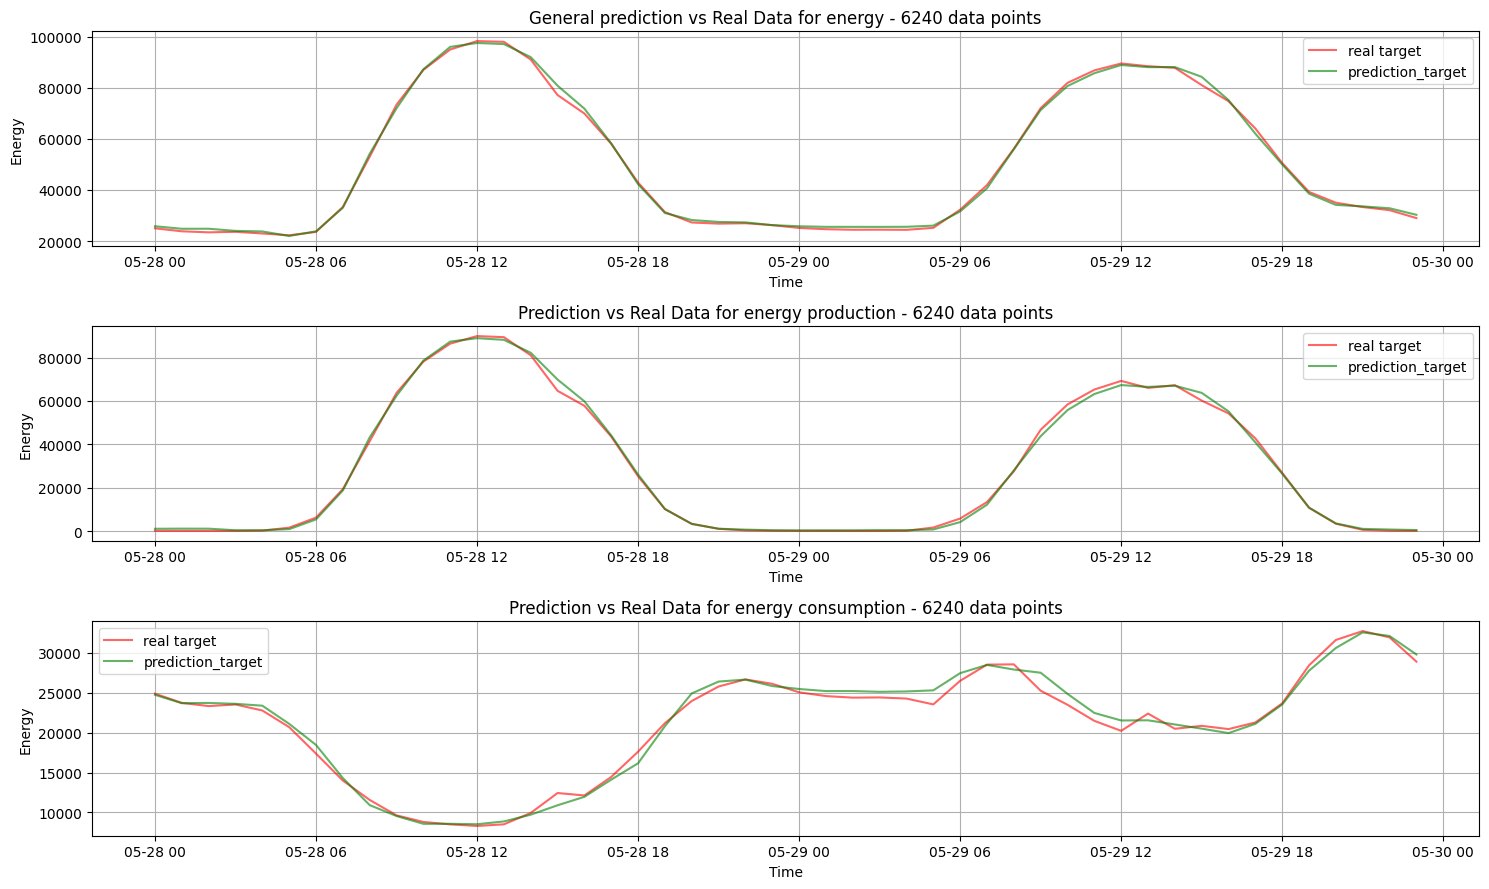

In [29]:
import matplotlib.pyplot as plt

fig, (ax,ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(15, 9))

number_data_points = len(df_revealed)

# First graph
ax.plot(df_prediction_grouped['target'], label='real target', color='r', alpha=0.6)
ax.plot(df_prediction_grouped['prediction_target'], label='prediction_target', color='g', alpha=0.6)
ax.set_title(f'General prediction vs Real Data for energy - {number_data_points} data points')
ax.set_xlabel('Time')
ax.set_ylabel('Energy')
ax.grid()
ax.legend()

# Second graph
ax1.plot(df_prediction_production_grouped['target'], label='real target', color='r', alpha=0.6)
ax1.plot(df_prediction_production_grouped['prediction_target'], label='prediction_target', color='g', alpha=0.6)
ax1.set_title(f'Prediction vs Real Data for energy production - {number_data_points} data points')
ax1.set_xlabel('Time')
ax1.set_ylabel('Energy')
ax1.grid()
ax1.legend()

# Third graph
ax2.plot(df_prediction_consumption_grouped['target'], label='real target', color='r', alpha=0.6)
ax2.plot(df_prediction_consumption_grouped['prediction_target'], label='prediction_target', color='g', alpha=0.6)
ax2.set_title(f'Prediction vs Real Data for energy consumption - {number_data_points} data points')
ax2.set_xlabel('Time')
ax2.set_ylabel('Energy')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

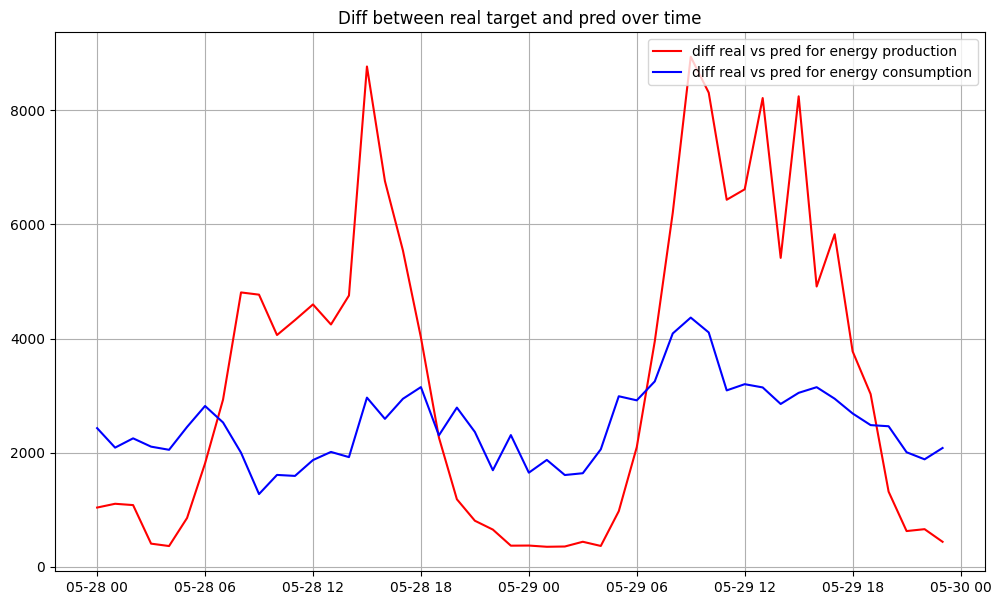

In [30]:
plt.figure(figsize=(12,7))

plt.plot(df_prediction_production_grouped['diff_target'], label='diff real vs pred for energy production', color='r')
plt.plot(df_prediction_consumption_grouped['diff_target'], label='diff real vs pred for energy consumption', color='b')

plt.title('Diff between real target and pred over time')
plt.legend()
plt.grid()
plt.show()

##

# 5 - Study the prediction for leftover from train set (30% of the train set)

In [31]:
y_pred_from_leftovertrain_serie = pd.Series(y_pred_from_leftovertrain, name='y_pred')
y_test_serie = pd.Series(y_test, name='y_true')
y_pred_from_leftovertrain_serie.index = X_test.index
y_test_serie.index = X_test.index

df_leftovertrain = pd.concat([X_test, y_pred_from_leftovertrain_serie,y_test_serie], axis=1)
df_leftovertrain['datetime'] = pd.to_datetime(df_leftovertrain[['year', 'month', 'day', 'hour']].assign(minute=0, second=0))

## 5.1 - General view

In [32]:
# Calculate the difference between the prediction and the real target
df_leftovertrain['diff_target'] = np.abs(df_leftovertrain['y_pred'] - df_leftovertrain['y_true'])

# Create 2 dataframes, one for the consumption and one for the production
df_leftovertrain_consumption = df_leftovertrain[df_leftovertrain['is_consumption']==1]
df_leftovertrain_production = df_leftovertrain[df_leftovertrain['is_consumption']==0]

# Group the data per date
df_leftovertrain_grouped = df_leftovertrain.groupby(by='datetime').sum()
df_leftovertrain_consumption_grouped = df_leftovertrain_consumption.groupby(by='datetime').sum()
df_leftovertrain_production_grouped = df_leftovertrain_production.groupby(by='datetime').sum()

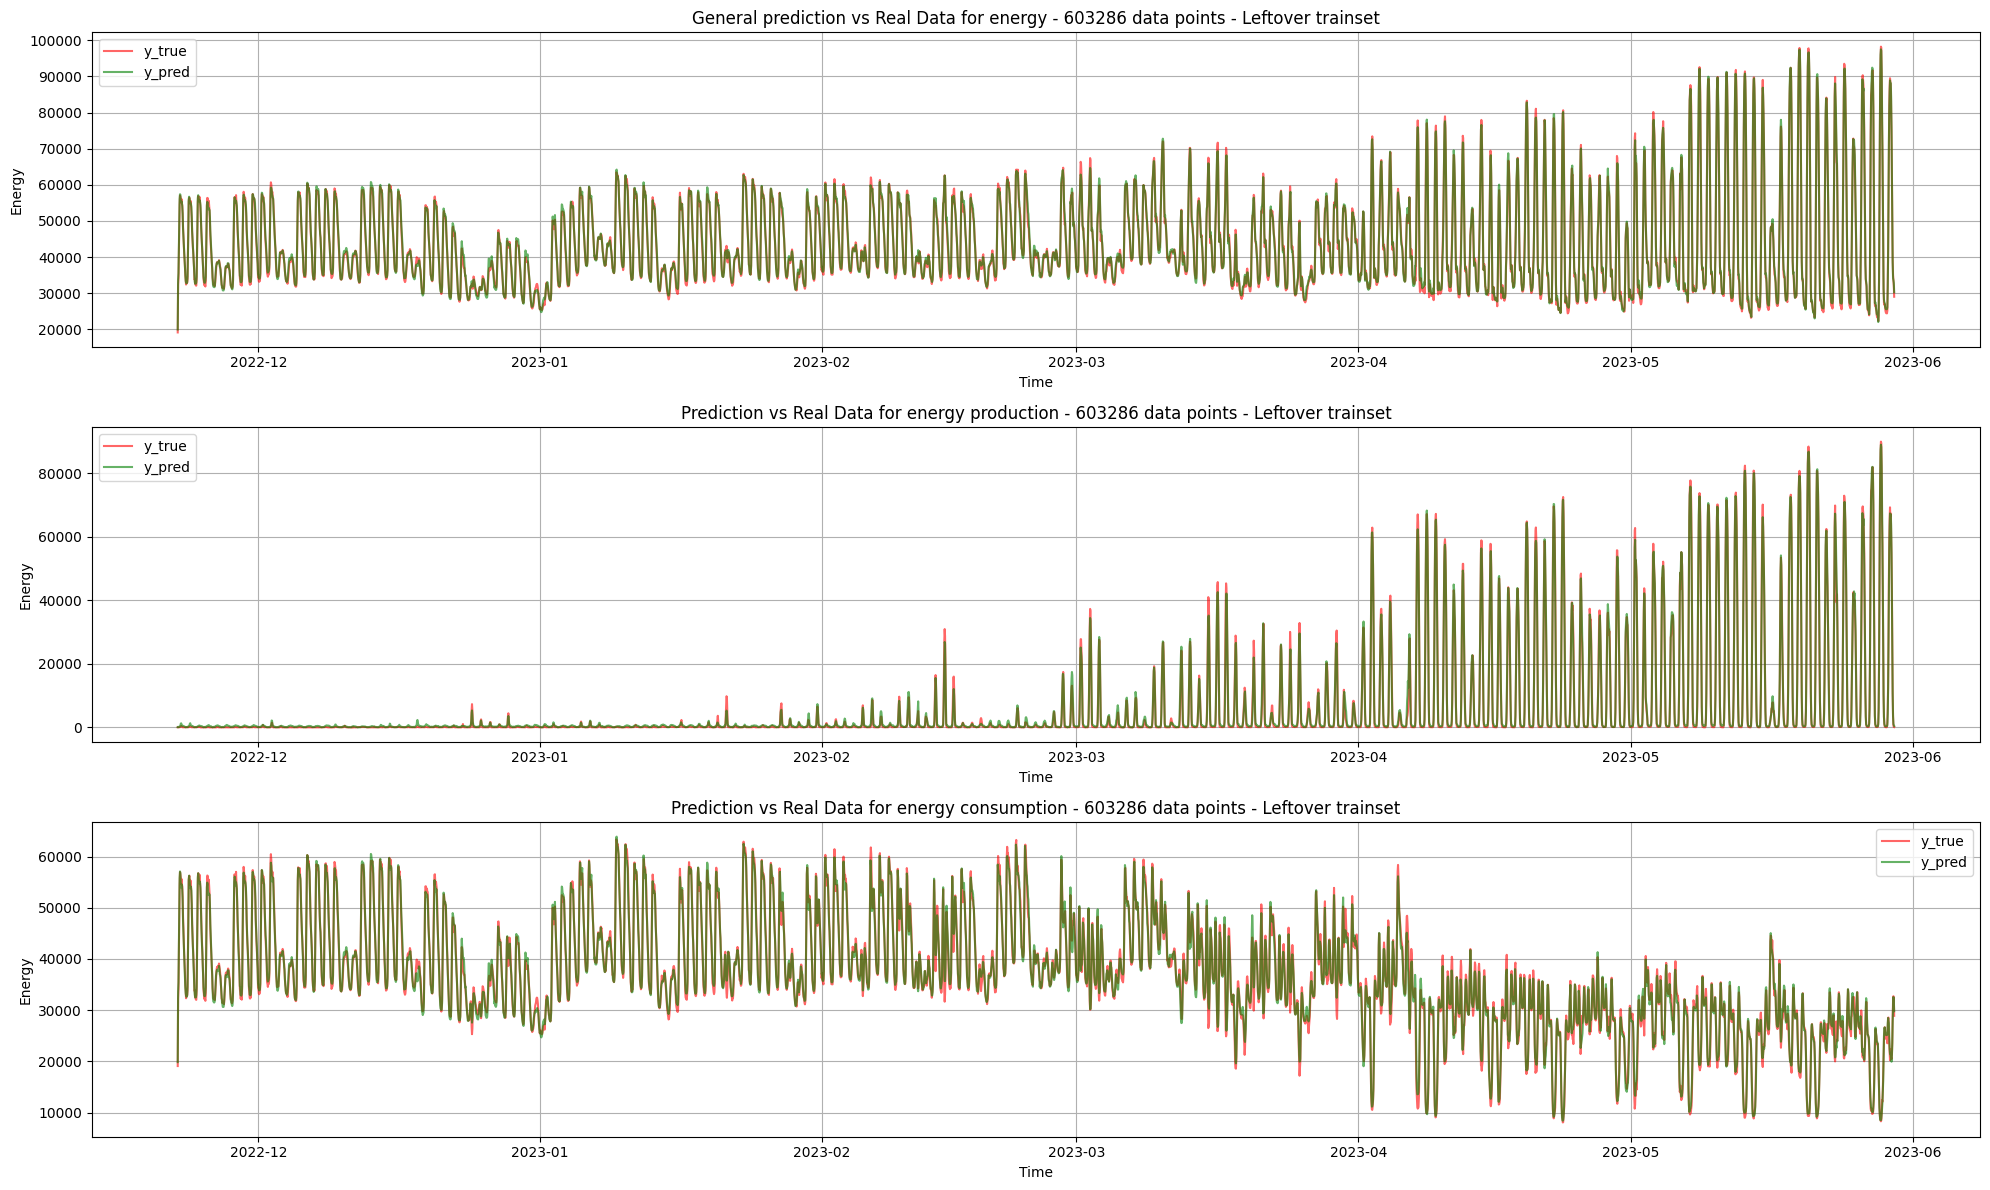

In [33]:
import matplotlib.pyplot as plt

fig, (ax,ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(20, 12))

number_data_points = len(df_leftovertrain)

# First graph
ax.plot(df_leftovertrain_grouped['y_true'], label='y_true', color='r', alpha=0.6)
ax.plot(df_leftovertrain_grouped['y_pred'], label='y_pred', color='g', alpha=0.6)
ax.set_title(f'General prediction vs Real Data for energy - {number_data_points} data points - Leftover trainset')
ax.set_xlabel('Time')
ax.set_ylabel('Energy')
ax.grid()
ax.legend()

# Second graph
ax1.plot(df_leftovertrain_production_grouped['y_true'], label='y_true', color='r', alpha=0.6)
ax1.plot(df_leftovertrain_production_grouped['y_pred'], label='y_pred', color='g', alpha=0.6)
ax1.set_title(f'Prediction vs Real Data for energy production - {number_data_points} data points - Leftover trainset')
ax1.set_xlabel('Time')
ax1.set_ylabel('Energy')
ax1.grid()
ax1.legend()

# Third graph
ax2.plot(df_leftovertrain_consumption_grouped['y_true'], label='y_true', color='r', alpha=0.6)
ax2.plot(df_leftovertrain_consumption_grouped['y_pred'], label='y_pred', color='g', alpha=0.6)
ax2.set_title(f'Prediction vs Real Data for energy consumption - {number_data_points} data points - Leftover trainset')
ax2.set_xlabel('Time')
ax2.set_ylabel('Energy')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

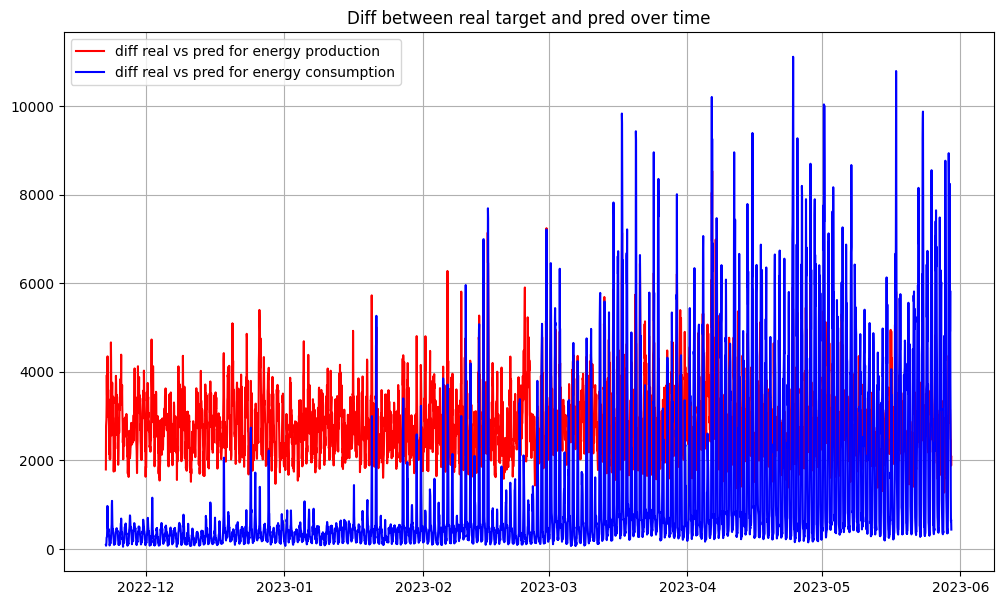

In [34]:
plt.figure(figsize=(12,7))

plt.plot(df_leftovertrain_consumption_grouped['diff_target'], label='diff real vs pred for energy production', color='r')
plt.plot(df_leftovertrain_production_grouped['diff_target'], label='diff real vs pred for energy consumption', color='b')

plt.title('Diff between real target and pred over time')
plt.legend()
plt.grid()
plt.show()

## 5.2 - Focus on one month - April

In [35]:
df_leftovertrain_focus = df_leftovertrain.loc[df_leftovertrain['month'] == 4]

In [36]:
# Calculate the difference between the prediction and the real target
df_leftovertrain_focus['diff_target'] = np.abs(df_leftovertrain_focus['y_pred'] - df_leftovertrain_focus['y_true'])

# Create 2 dataframes, one for the consumption and one for the production
df_leftovertrain_focus_consumption = df_leftovertrain_focus[df_leftovertrain_focus['is_consumption']==1]
df_leftovertrain_focus_production = df_leftovertrain_focus[df_leftovertrain_focus['is_consumption']==0]

# Group the data per date
df_leftovertrain_focus_grouped = df_leftovertrain_focus.groupby(by='datetime').sum()
df_leftovertrain_consumption_focus_grouped = df_leftovertrain_focus_consumption.groupby(by='datetime').sum()
df_leftovertrain_production_focus_grouped = df_leftovertrain_focus_production.groupby(by='datetime').sum()

/var/folders/qx/vs5kgv557012y73k70gg87640000gn/T/ipykernel_3935/1586898615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_leftovertrain_focus['diff_target'] = np.abs(df_leftovertrain_focus['y_pred'] - df_leftovertrain_focus['y_true'])


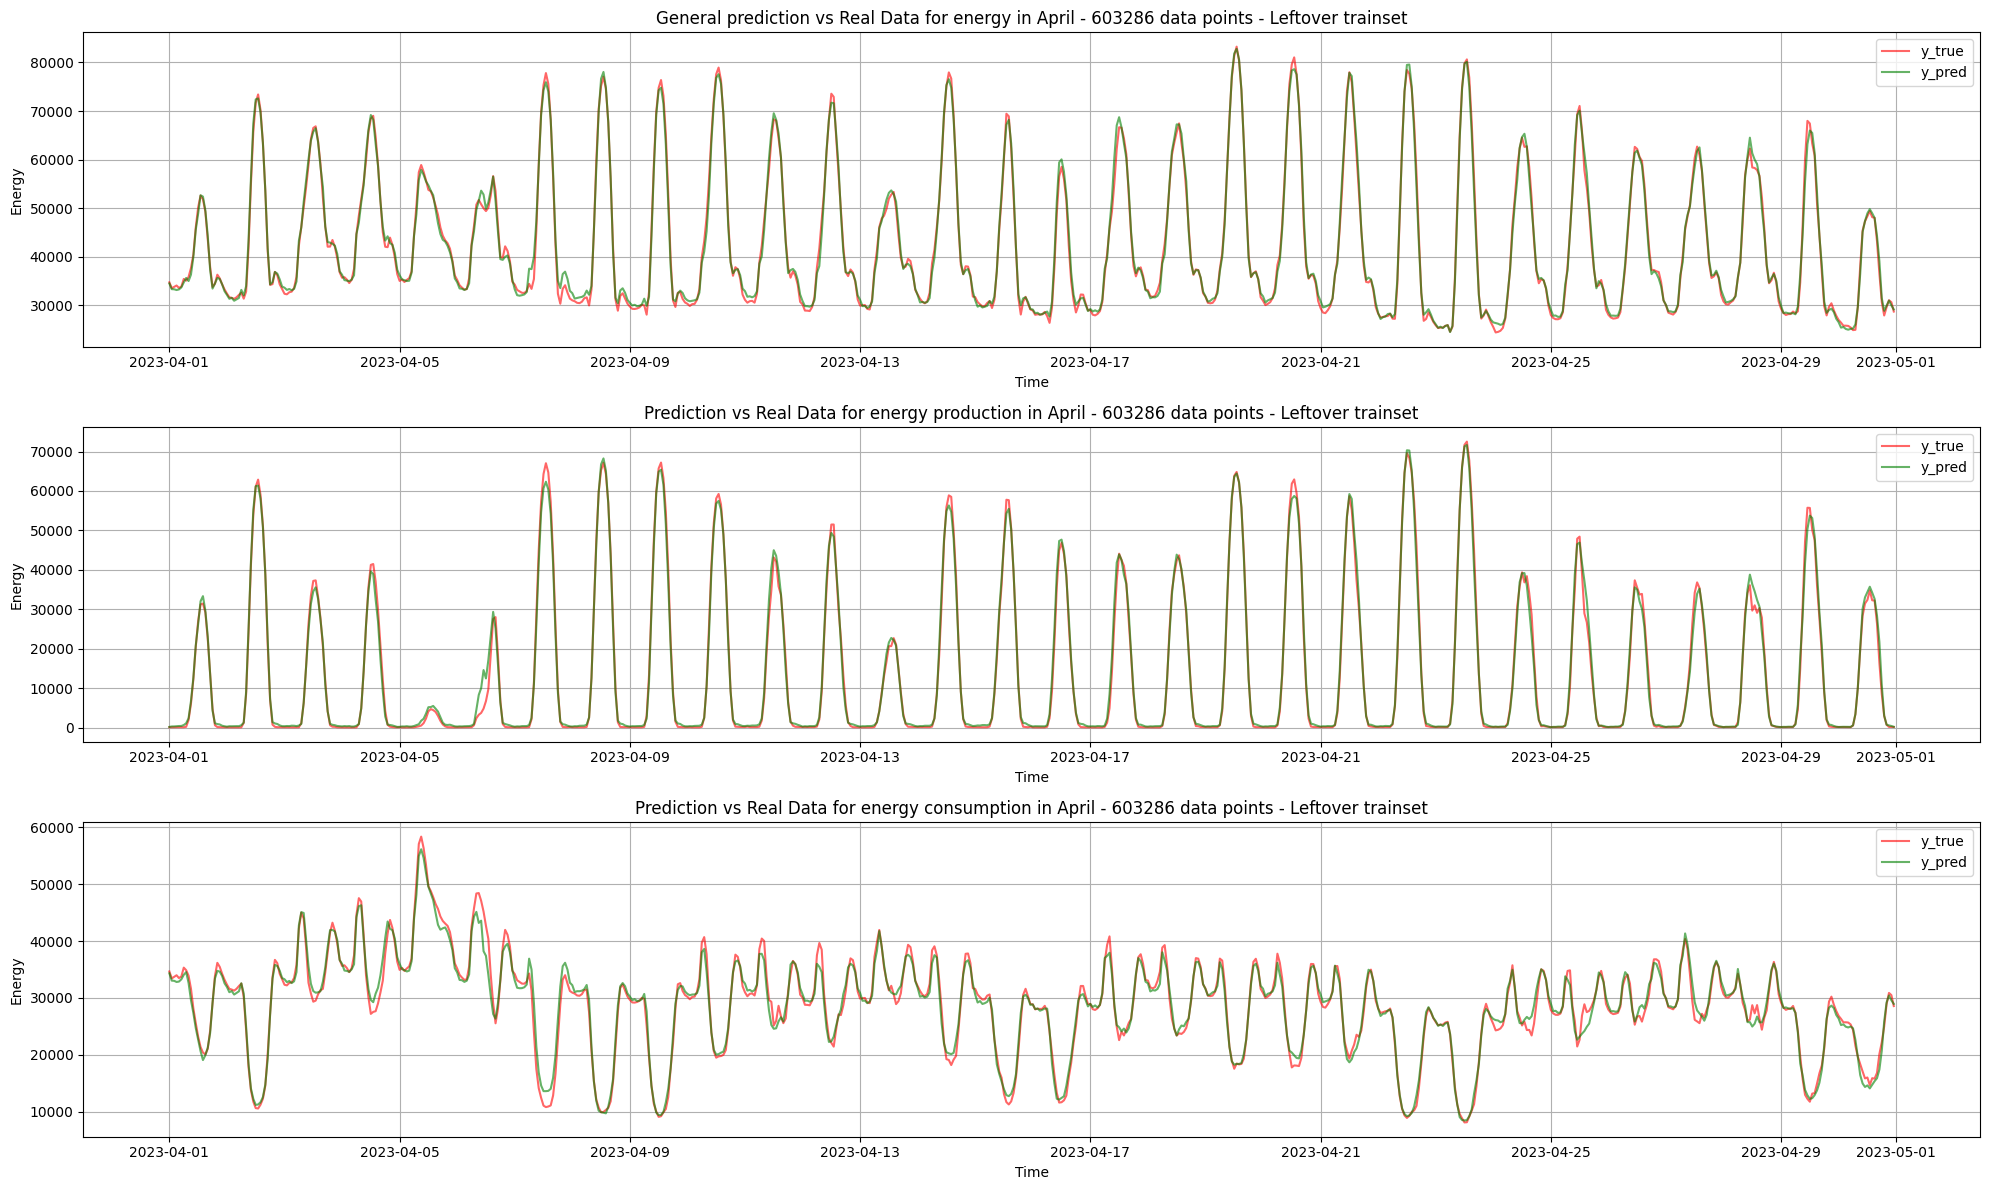

In [37]:
import matplotlib.pyplot as plt

fig, (ax,ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(20, 12))

number_data_points = len(df_leftovertrain)

# First graph
ax.plot(df_leftovertrain_focus_grouped['y_true'], label='y_true', color='r', alpha=0.6)
ax.plot(df_leftovertrain_focus_grouped['y_pred'], label='y_pred', color='g', alpha=0.6)
ax.set_title(f'General prediction vs Real Data for energy in April - {number_data_points} data points - Leftover trainset')
ax.set_xlabel('Time')
ax.set_ylabel('Energy')
ax.grid()
ax.legend()

# Second graph
ax1.plot(df_leftovertrain_production_focus_grouped['y_true'], label='y_true', color='r', alpha=0.6)
ax1.plot(df_leftovertrain_production_focus_grouped['y_pred'], label='y_pred', color='g', alpha=0.6)
ax1.set_title(f'Prediction vs Real Data for energy production in April - {number_data_points} data points - Leftover trainset')
ax1.set_xlabel('Time')
ax1.set_ylabel('Energy')
ax1.grid()
ax1.legend()

# Third graph
ax2.plot(df_leftovertrain_consumption_focus_grouped['y_true'], label='y_true', color='r', alpha=0.6)
ax2.plot(df_leftovertrain_consumption_focus_grouped['y_pred'], label='y_pred', color='g', alpha=0.6)
ax2.set_title(f'Prediction vs Real Data for energy consumption in April - {number_data_points} data points - Leftover trainset')
ax2.set_xlabel('Time')
ax2.set_ylabel('Energy')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

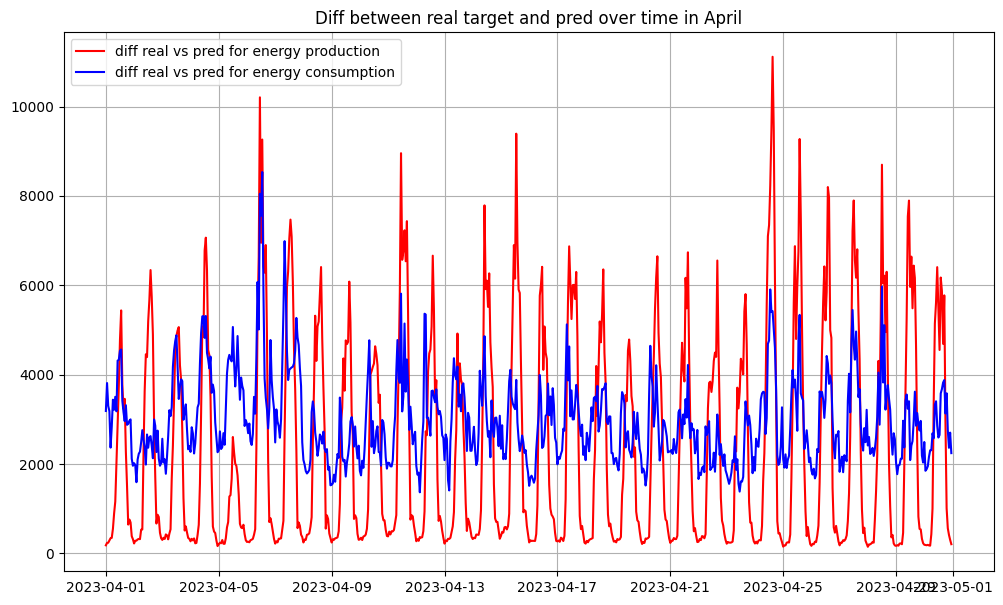

In [38]:
plt.figure(figsize=(12,7))

plt.plot(df_leftovertrain_production_focus_grouped['diff_target'], label='diff real vs pred for energy production', color='r')
plt.plot(df_leftovertrain_consumption_focus_grouped['diff_target'], label='diff real vs pred for energy consumption', color='b')

plt.title('Diff between real target and pred over time in April')
plt.legend()
plt.grid()
plt.show()

## 5.3 - Focus where the model didnt perfom well

In [39]:
#Calculate the percentage of precision of y_pred compared to y_true
df_leftovertrain['percentage_precision'] = df_leftovertrain['y_pred'] * 100 / df_leftovertrain['y_true']

#Tag 0 for prediction != 0 when y_true is equal to 0
df_leftovertrain['percentage_precision'].replace([np.inf, -np.inf], 0, inplace=True)

#Remplace Nan per 100% since nan appears when y_pred = 0 and y_true = 0
df_leftovertrain['percentage_precision'].fillna(100, inplace=True)

#Focus on the prediction below 25% of precision
df_leftovertrain_under_25 = df_leftovertrain[(df_leftovertrain['percentage_precision'] < 25) & (df_leftovertrain['percentage_precision'] > 0)]

#Create 2 dataframes, 1 for prod and 1 for cons
df_leftovertrain_under_25_prod = df_leftovertrain_under_25[df_leftovertrain_under_25['is_consumption'] == 0]
df_leftovertrain_under_25_cons = df_leftovertrain_under_25[df_leftovertrain_under_25['is_consumption'] == 1]

#Group data per date
df_leftovertrain_under_25_prod_grouped = df_leftovertrain_under_25_prod.groupby(by='datetime').sum()
df_leftovertrain_under_25_cons_grouped = df_leftovertrain_under_25_cons.groupby(by='datetime').sum()

In [40]:
df_leftovertrain_under_25_prod['count'] = 1
df_leftovertrain_under_25_cons['count'] = 1

df_leftovertrain_under_25_prod_grouped_month = df_leftovertrain_under_25_prod.groupby(by=['month']).sum()
df_leftovertrain_under_25_cons_grouped_month = df_leftovertrain_under_25_cons.groupby(by=['month']).sum()

df_leftovertrain_under_25_prod_grouped_week = df_leftovertrain_under_25_prod.groupby(by=['week']).sum()
df_leftovertrain_under_25_cons_grouped_week = df_leftovertrain_under_25_cons.groupby(by=['week']).sum()

df_leftovertrain_under_25_prod_grouped_hours = df_leftovertrain_under_25_prod.groupby(by=['hour']).sum()
df_leftovertrain_under_25_cons_grouped_hours = df_leftovertrain_under_25_cons.groupby(by=['hour']).sum()

df_leftovertrain_under_25_prod_grouped_day = df_leftovertrain_under_25_prod.groupby(by=['day']).sum()
df_leftovertrain_under_25_cons_grouped_day = df_leftovertrain_under_25_cons.groupby(by=['day']).sum()

/var/folders/qx/vs5kgv557012y73k70gg87640000gn/T/ipykernel_3935/1819480537.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_leftovertrain_under_25_prod['count'] = 1
/var/folders/qx/vs5kgv557012y73k70gg87640000gn/T/ipykernel_3935/1819480537.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_leftovertrain_under_25_cons['count'] = 1


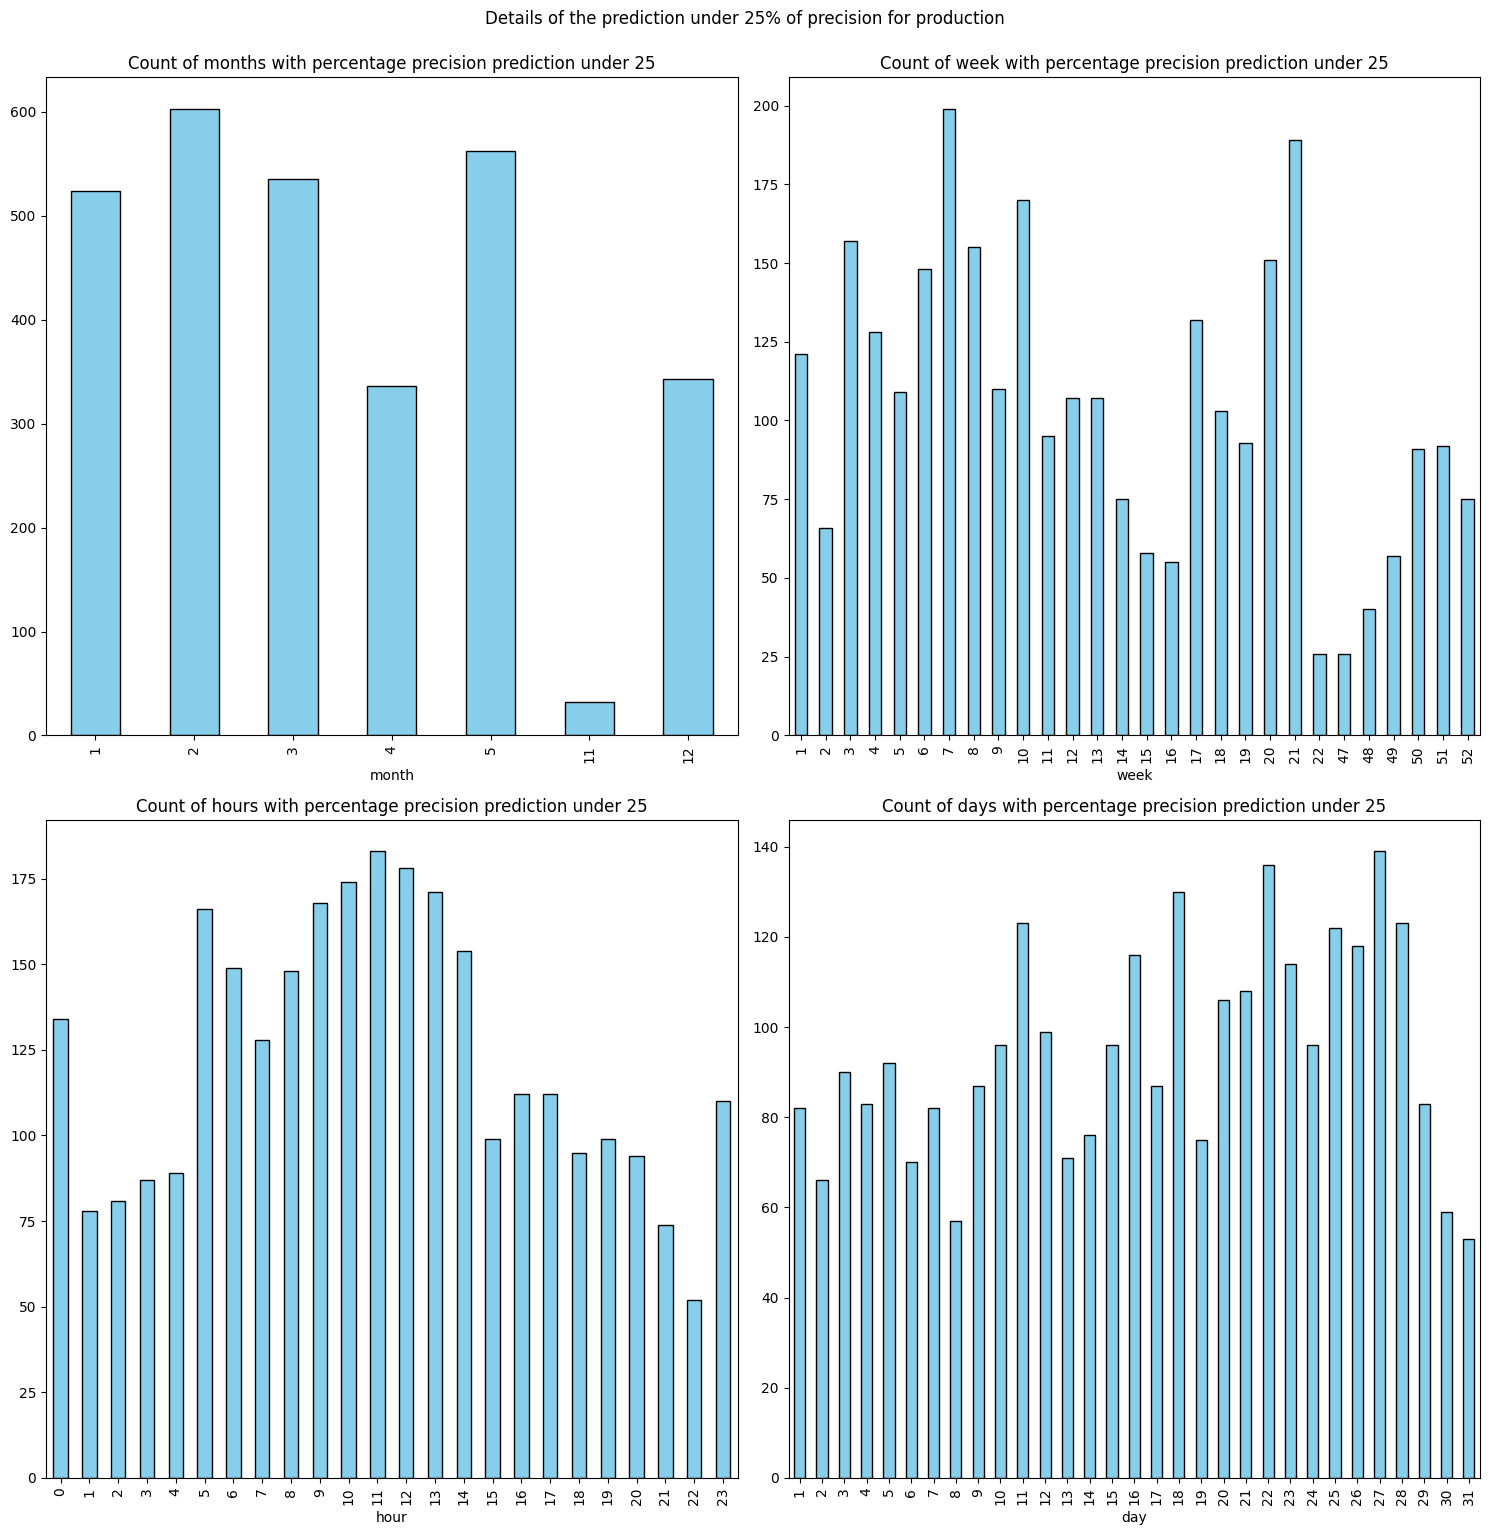

In [41]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,15))


df_leftovertrain_under_25_prod_grouped_month['count'].plot.bar(ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Count of months with percentage precision prediction under 25')

df_leftovertrain_under_25_prod_grouped_week['count'].plot.bar(ax=ax2, color='skyblue', edgecolor='black')
ax2.set_title('Count of week with percentage precision prediction under 25')

df_leftovertrain_under_25_prod_grouped_hours['count'].plot.bar(ax=ax3, color='skyblue', edgecolor='black')
ax3.set_title('Count of hours with percentage precision prediction under 25')

df_leftovertrain_under_25_prod_grouped_day['count'].plot.bar(ax=ax4, color='skyblue', edgecolor='black')
ax4.set_title('Count of days with percentage precision prediction under 25')

plt.tight_layout()
plt.suptitle('Details of the prediction under 25% of precision for production', y=1.02)
plt.show()

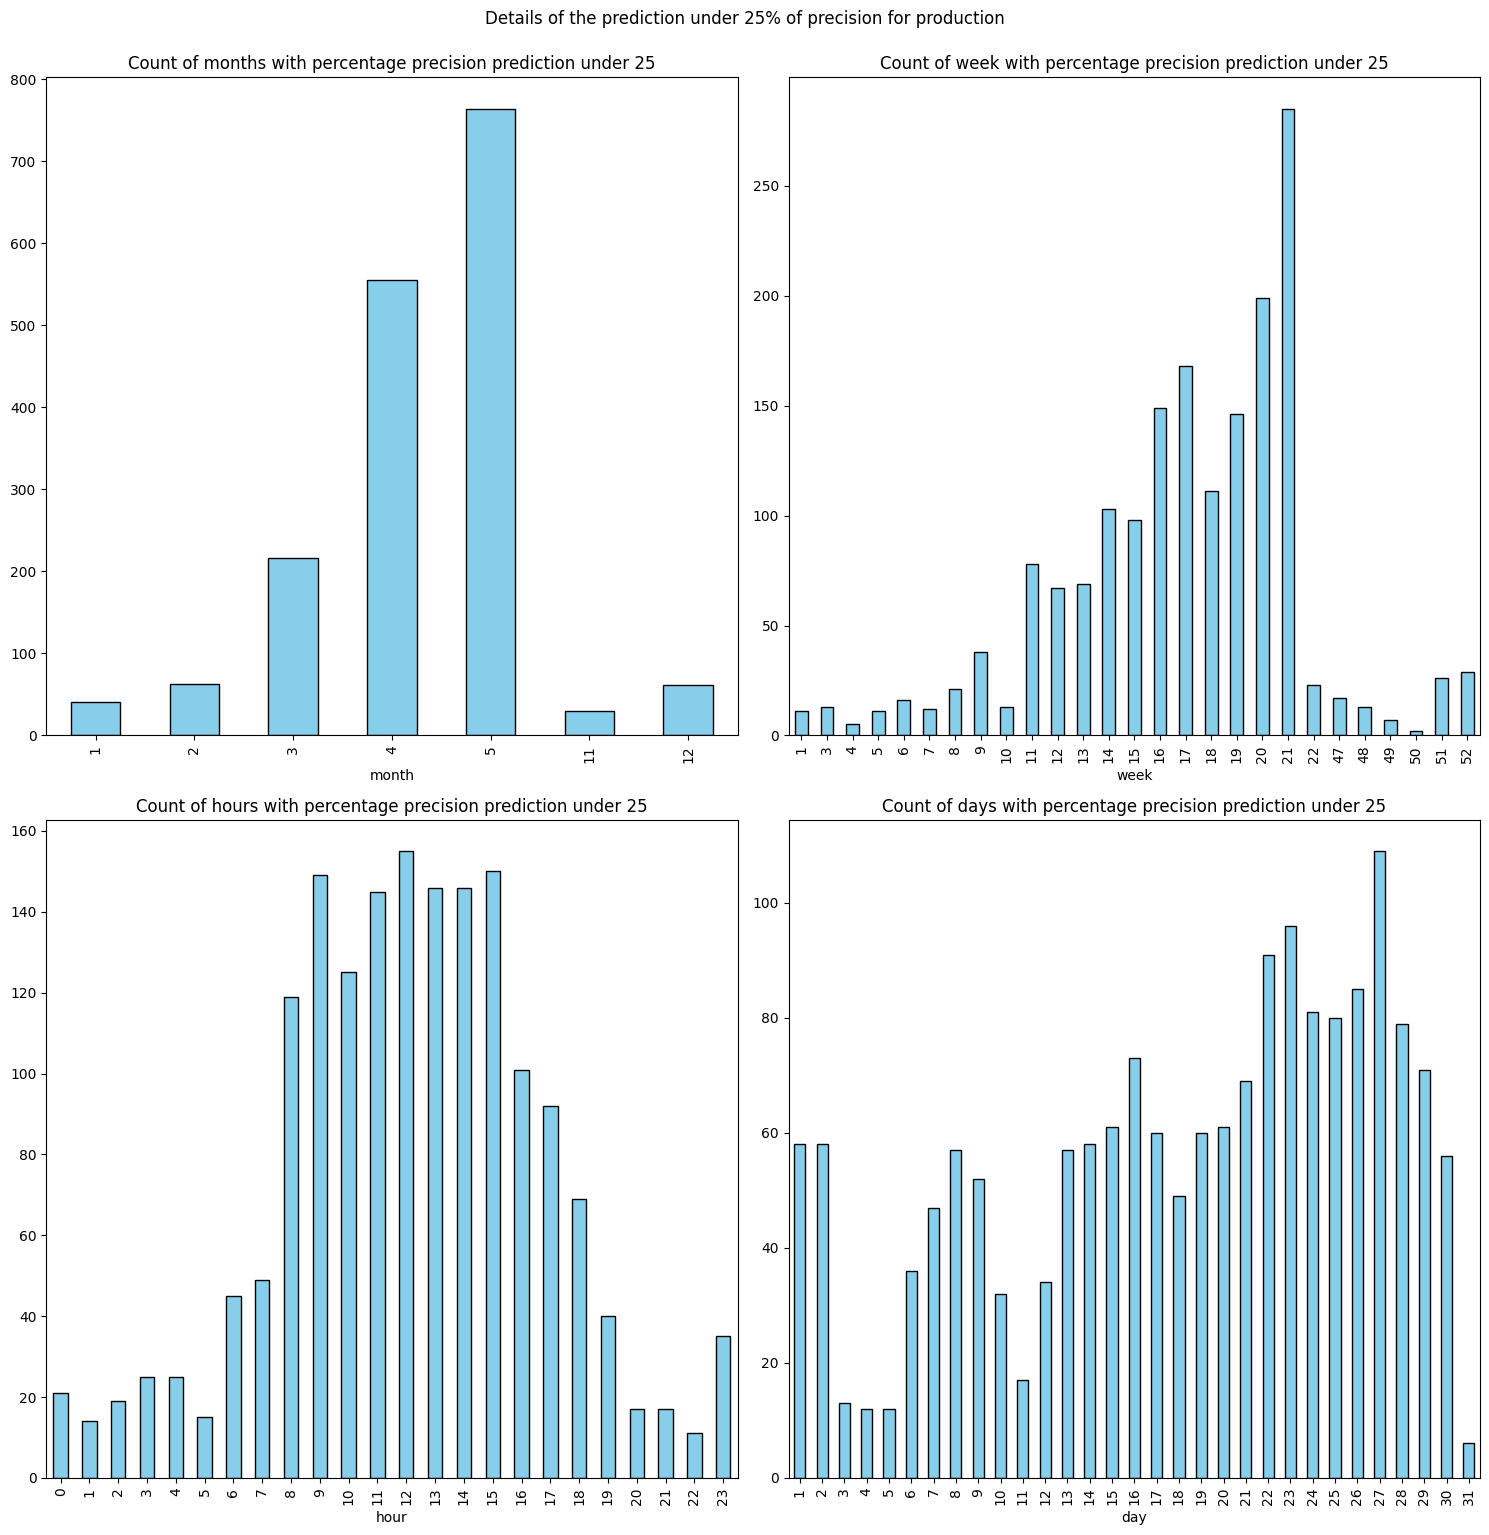

In [42]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,15))


df_leftovertrain_under_25_cons_grouped_month['count'].plot.bar(ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Count of months with percentage precision prediction under 25')

df_leftovertrain_under_25_cons_grouped_week['count'].plot.bar(ax=ax2, color='skyblue', edgecolor='black')
ax2.set_title('Count of week with percentage precision prediction under 25')

df_leftovertrain_under_25_cons_grouped_hours['count'].plot.bar(ax=ax3, color='skyblue', edgecolor='black')
ax3.set_title('Count of hours with percentage precision prediction under 25')

df_leftovertrain_under_25_cons_grouped_day['count'].plot.bar(ax=ax4, color='skyblue', edgecolor='black')
ax4.set_title('Count of days with percentage precision prediction under 25')

plt.tight_layout()
plt.suptitle('Details of the prediction under 25% of precision for production', y=1.02)
plt.show()

## 5.4 - Imbalance cost

In [43]:
#Both dataset have the same number of rows, which means that
df_leftovertrain_production.shape , df_leftovertrain_consumption.shape

((301643, 61), (301643, 61))

In [44]:
df_leftovertrain_consumption.head()

county  is_business  product_type  is_consumption  data_block_id  \
1407667       2            0             1               1            447   
1407669       2            0             3               1            447   
1407671       2            1             1               1            447   
1407673       2            1             3               1            447   
1407675       3            0             1               1            447   

          row_id  prediction_unit_id  lowest_price_per_mwh  \
1407667  1408563                  62                121.41   
1407669  1408565                   9                121.41   
1407671  1408567                  65                121.41   
1407673  1408569                  10                121.41   
1407675  1408571                  11                121.41   

         highest_price_per_mwh  eic_count  installed_capacity  euros_per_mwh  \
1407667                  130.0       47.0              1707.7         200.63   
1407669                  130.0       47.0              1707.7         200.63   
1407671                  130.0       47.0              1707.7         200.63   
1407673                  130.0       47.0              1707.7         200.63   
1407675                  130.0       47.0              1707.7         200.63   

         temperature_x  dewpoint_x  rain  snowfall_x  surface_pressure  \
1407667      -5.450000      -8.525   0.0         0.0          1010.025   
1407669      -5.450000      -8.525   0.0         0.0          1010.025   
1407671      -5.450000      -8.525   0.0         0.0          1010.025   
1407673      -5.450000      -8.525   0.0         0.0          1010.025   
1407675      -5.333333      -7.100   0.0         0.0          1005.500   

         cloudcover_total_x  cloudcover_low_x  cloudcover_mid_x  \
1407667               100.0         86.000000              79.0   
1407669               100.0         86.000000              79.0   
1407671               100.0         86.000000              79.0   
1407673               100.0         86.000000              79.0   
1407675               100.0         99.666667              33.0   

         cloudcover_high_x  windspeed_10m  winddirection_10m  \
1407667          82.500000       3.479167         344.750000   
1407669          82.500000       3.479167         344.750000   
1407671          82.500000       3.479167         344.750000   
1407673          82.500000       3.479167         344.750000   
1407675           9.333333       3.240741         345.333333   

         shortwave_radiation  direct_solar_radiation_x  diffuse_radiation  \
1407667                  0.0                       0.0                0.0   
1407669                  0.0                       0.0                0.0   
1407671                  0.0                       0.0                0.0   
1407673                  0.0                       0.0                0.0   
1407675                  0.0                       0.0                0.0   

         latitude_x  longitude_x  latitude_y  longitude_y  hours_ahead  \
1407667       59.25    27.450000       59.25    27.450000         14.0   
1407669       59.25    27.450000       59.25    27.450000         14.0   
1407671       59.25    27.450000       59.25    27.450000         14.0   
1407673       59.25    27.450000       59.25    27.450000         14.0   
1407675       58.90    25.533333       58.90    25.533333         14.0   

         temperature_y  dewpoint_y  cloudcover_high_y  cloudcover_low_y  \
1407667      -4.590063   -7.737921           0.660000          0.521164   
1407669      -4.590063   -7.737921           0.660000          0.521164   
1407671      -4.590063   -7.737921           0.660000          0.521164   
1407673      -4.590063   -7.737921           0.660000          0.521164   
1407675      -4.165218   -6.035091           0.104914          0.999992   

         cloudcover_mid_y  cloudcover_total_y  10_metre_u_wind_component  \
1407667          0.93915

In [45]:
df_leftovertrain_production2 = df_leftovertrain_production.copy().reset_index()
df_leftovertrain_consumption2 = df_leftovertrain_consumption.copy().reset_index()

#Calculate the balance between the production and the consumption
df_leftovertrain_production2['Energy_balance_pred'] = df_leftovertrain_production2['y_pred'] - df_leftovertrain_consumption2['y_pred']
df_leftovertrain_production2['Energy_balance_true'] = df_leftovertrain_production2['y_true'] - df_leftovertrain_consumption2['y_true']
df_leftovertrain_production2['Energy_balance_diff'] = df_leftovertrain_production2['Energy_balance_pred'] - df_leftovertrain_production2['Energy_balance_true']

#Calculate the cost of the balance
df_leftovertrain_production2['Cost_of_balance_diff'] = df_leftovertrain_production2['Energy_balance_diff'] * df_leftovertrain_production2['euros_per_mwh']
df_leftovertrain_production2['Cumulative_cos'] = df_leftovertrain_production2['Cost_of_balance_diff'].cumsum()

#Group the data per datetime
df_leftovertrain_production2_grouped = df_leftovertrain_production2.groupby(by='datetime').sum()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


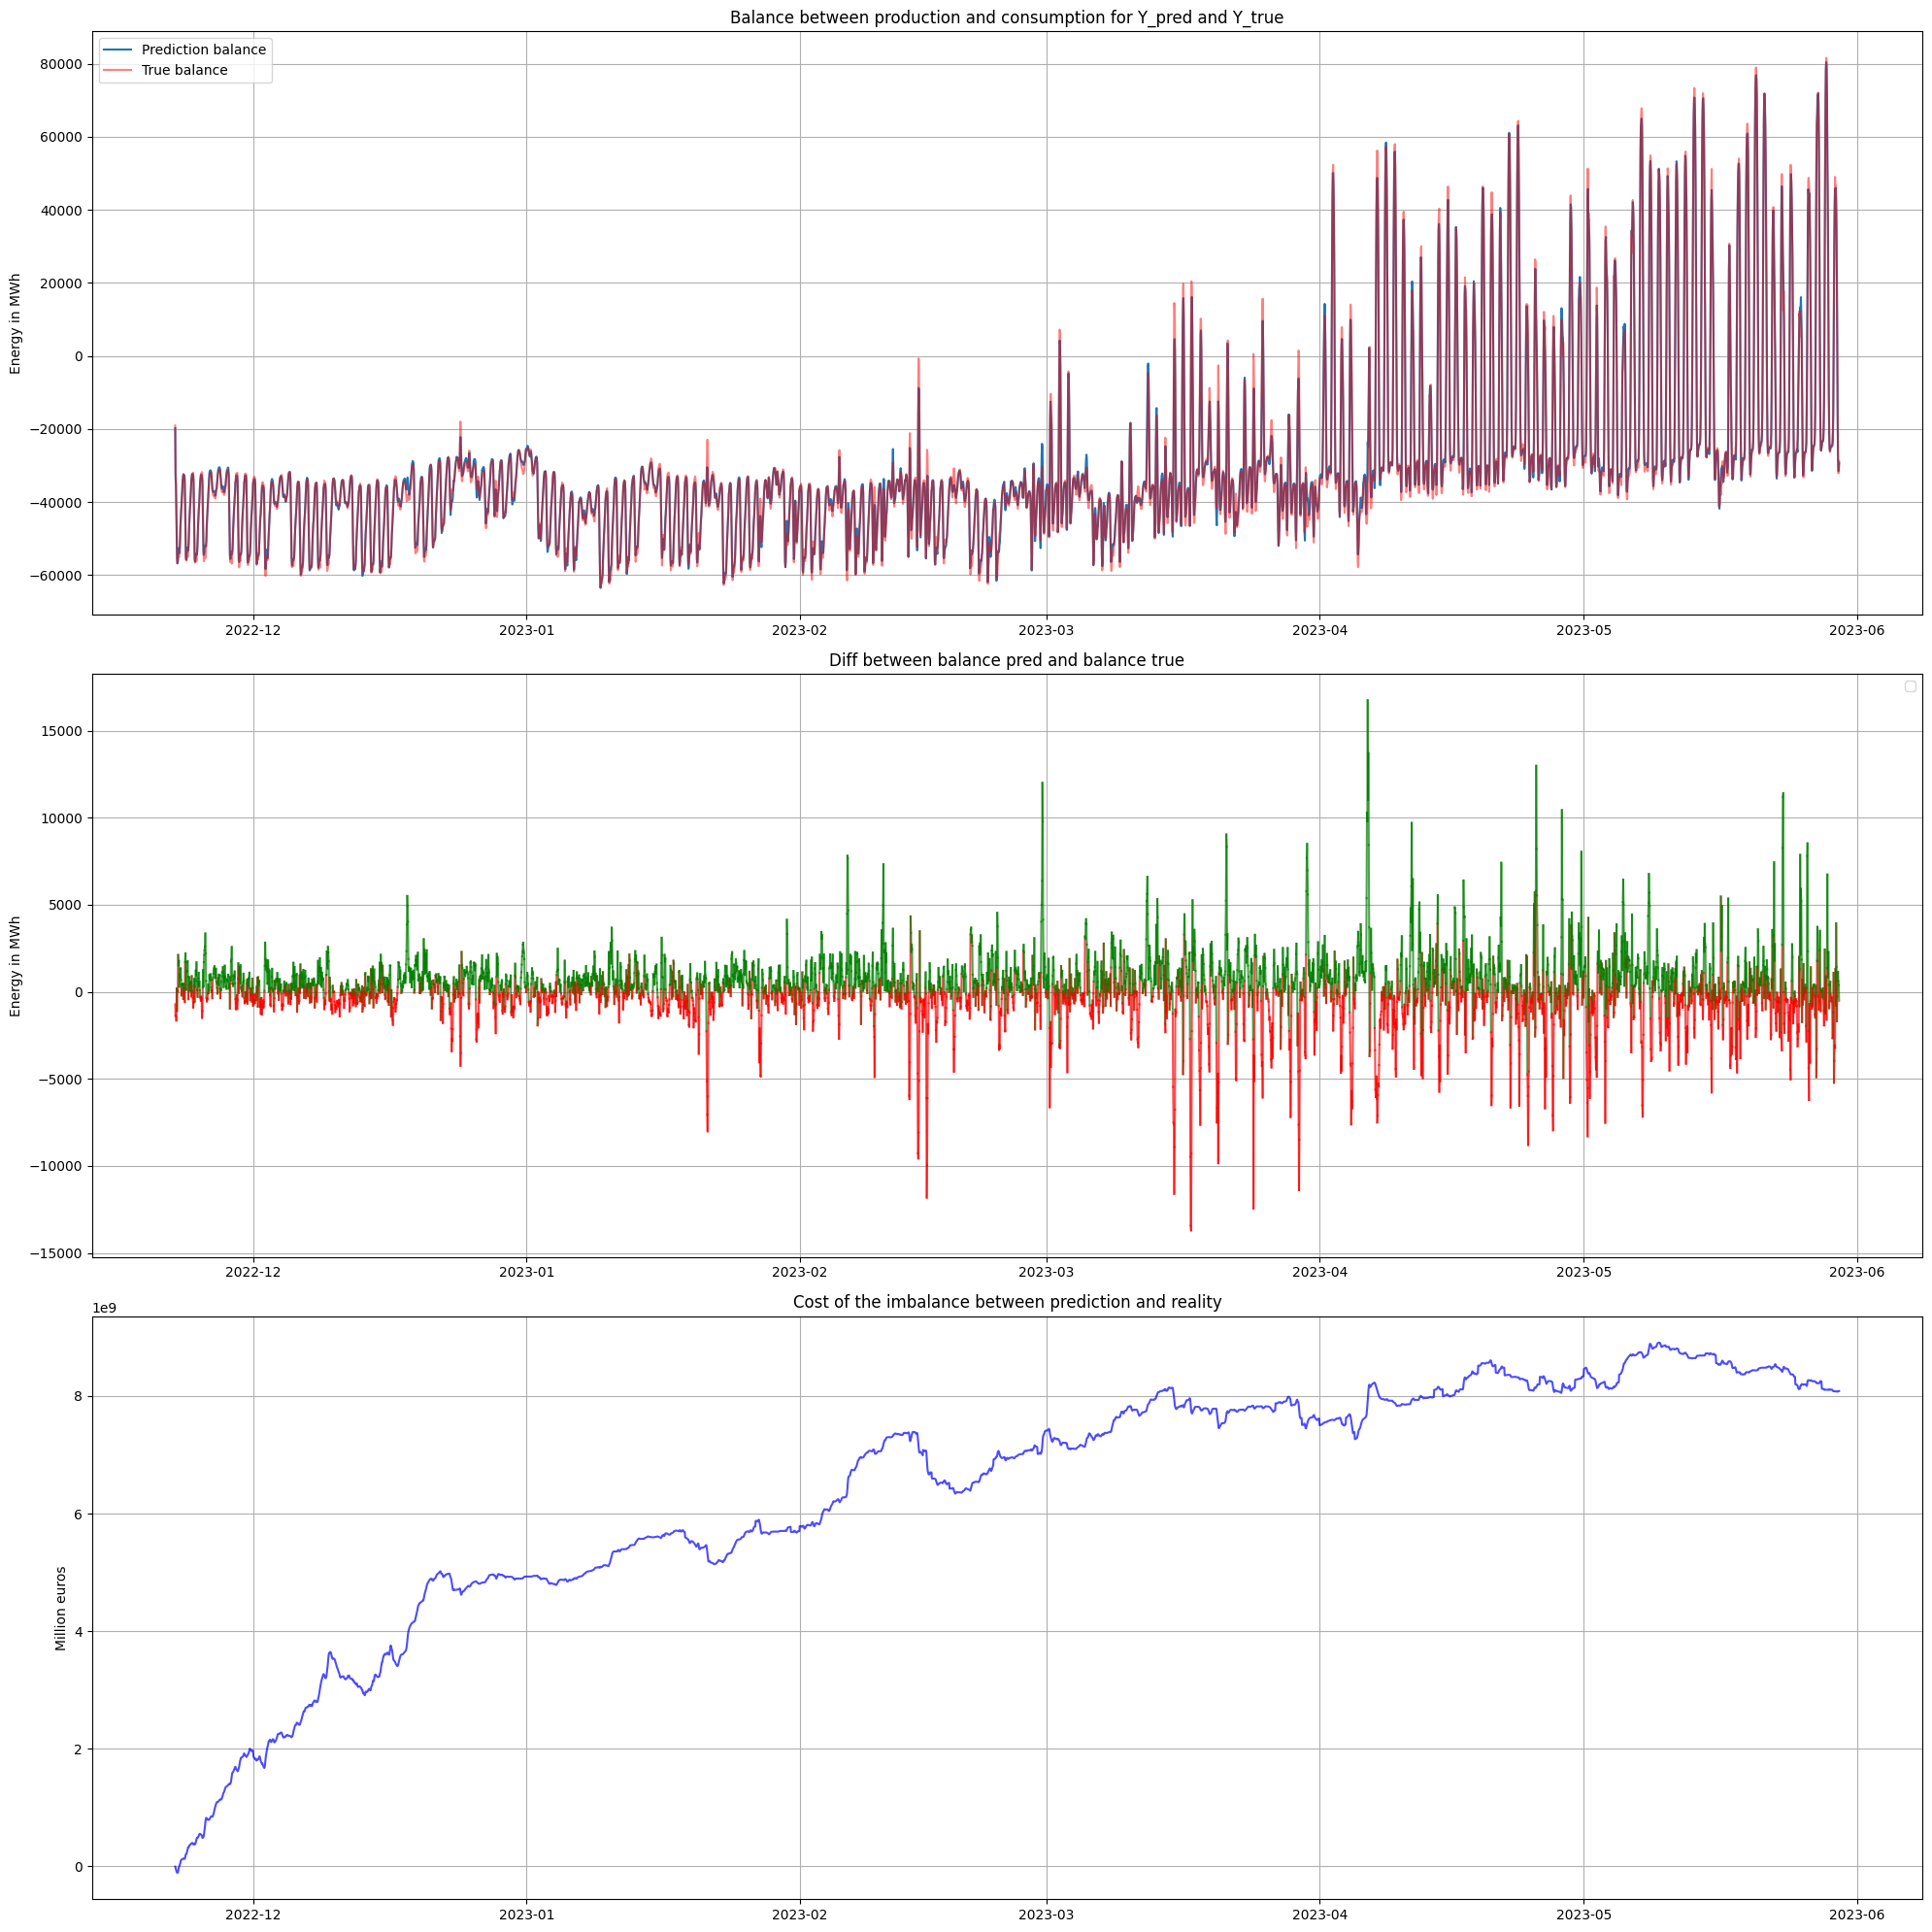

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(20,20))

ax1.plot(df_leftovertrain_production2_grouped['Energy_balance_pred'], label='Prediction balance', alpha=1)
ax1.plot(df_leftovertrain_production2_grouped['Energy_balance_true'], label='True balance',color='r', alpha=0.5)
ax1.grid()
ax1.set_title('Balance between production and consumption for Y_pred and Y_true')
ax1.set_ylabel('Energy in MWh')
ax1.legend()

#ax2.plot(df_leftovertrain_production2_grouped['Energy_balance_diff'], label='Balance pred - Balance true', color='green',alpha=0.7)
balance_diff = df_leftovertrain_production2_grouped['Energy_balance_diff']

for i in range(len(balance_diff) - 1):
    color = 'red' if balance_diff.iloc[i] < 0 else 'green'
    ax2.plot(balance_diff.index[i:i+2], balance_diff.iloc[i:i+2], color=color, alpha=0.7)

ax2.grid()
ax2.set_title('Diff between balance pred and balance true')
ax2.set_ylabel('Energy in MWh')
ax2.legend()

ax3.plot(df_leftovertrain_production2_grouped['Cumulative_cos'], color='blue',alpha=0.7)
ax3.grid()
ax3.set_title('Cost of the imbalance between prediction and reality')
ax3.set_ylabel('Million euros')

plt.tight_layout()
plt.show()

### 5.4.1 Define other models to compare the performance

2 new models will be defined as following:

1. Dummy model: for both the production and the consumption it is defined as the mean of the train set
2. Engineer model:
- For consumption, we assume that the previous year's consumption over the same period is the same as this year's
- For production, we assume that it is proportional to feature 'direct_solar_radiation'. We therefore use a rule of 3 to calculate production

In [47]:
#Recreate the train set
df_train = X_train.merge(y_train, left_index=True, right_index=True, how='inner')

In [48]:
#For consumption, we assume that the previous year's consumption over the same period is the same as this year's
df_train['year'] = df_train['year'] + 1
df_train['date2'] = pd.to_datetime(df_train[['year','month','day','hour']])

start_date = '2022-11-22 03:00:00'
end_date = '2023-05-29 23:00:00'

df_train_filtered = df_train.query('date2 >= @start_date and date2 <= @end_date')
df_train_filtered.rename(columns={'date2':'datetime'},inplace=True)

/var/folders/qx/vs5kgv557012y73k70gg87640000gn/T/ipykernel_3935/1537480604.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_filtered.rename(columns={'date2':'datetime'},inplace=True)


In [49]:
df_train_filtered_cons = df_train_filtered[df_train_filtered['is_consumption']==1]
df_train_filtered_cons = df_train_filtered_cons[['datetime','target']]
df_train_filtered_cons_grouped = df_train_filtered_cons.groupby('datetime').sum()
df_train_filtered_cons_grouped.rename(columns={'target':'y_pred_engineer'},inplace=True)

#Below is the consumption for this "engineer" model
df_train_filtered_cons_grouped.head()

y_pred_engineer
datetime                            
2022-11-22 03:00:00        23125.866
2022-11-22 04:00:00        23468.071
2022-11-22 05:00:00        24996.958
2022-11-22 06:00:00        30043.967
2022-11-22 07:00:00        35689.789

In [50]:
#Calculate the mean of the train set for the consumption. It will be used for the dummy model
df_train_cons = df_train[df_train['is_consumption']==1]
df_train_cons_grouped = df_train_cons.groupby('date2').sum()
df_train_cons_grouped['target'].mean()

27573.67280214452

In [51]:
#Merge dataset together for consumption in order to compare models
df_leftovertrain_consumption2_grouped = df_leftovertrain_consumption2.groupby('datetime').sum()
df_leftovertrain_consumption2_grouped2 = df_leftovertrain_consumption2_grouped.merge(df_train_filtered_cons_grouped, on='datetime', how='left')

In [52]:
#Add the dummy figures
df_leftovertrain_consumption2_grouped2['y_dummy'] = 27574

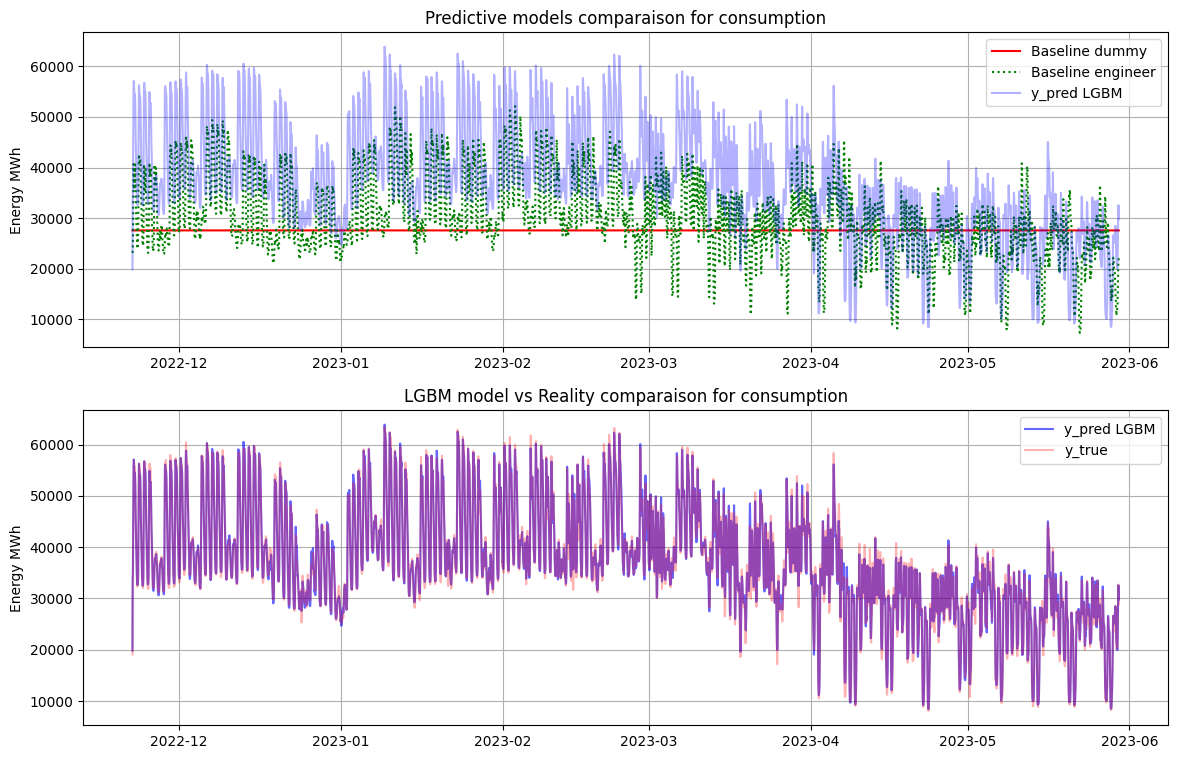

In [53]:
fig, (ax,ax1) = plt.subplots(2,1,figsize=(14,9))

#Compare the 3 models together: LGBM, dummy and engineer
ax.plot(df_leftovertrain_consumption2_grouped2['y_dummy'], label='Baseline dummy', color='red', alpha=1)
ax.plot(df_leftovertrain_consumption2_grouped2['y_pred_engineer'], label='Baseline engineer', color='green', linestyle=':', alpha=1)
ax.plot(df_leftovertrain_consumption2_grouped2['y_pred'], label='y_pred LGBM', color='blue', alpha=0.3)
ax.set_title('Predictive models comparaison for consumption')
ax.set_ylabel('Energy MWh')
ax.grid()
ax.legend()

#Compare LGBM and Reality
ax1.plot(df_leftovertrain_consumption2_grouped2['y_pred'], label='y_pred LGBM', color='blue', alpha=0.6)
ax1.plot(df_leftovertrain_consumption2_grouped2['y_true'], label='y_true', color='red', alpha=0.3)
ax1.set_title('LGBM model vs Reality comparaison for consumption')
ax1.set_ylabel('Energy MWh')
ax1.grid()
ax1.legend()

plt.show()

In [54]:
#Calculate the value for the dummy model
df_train_prod = df_train[df_train['is_consumption']==0]
df_train_prod_gruped = df_train_prod.groupby('date2').sum()
df_train_prod_gruped['target'].mean()

5368.884485967365

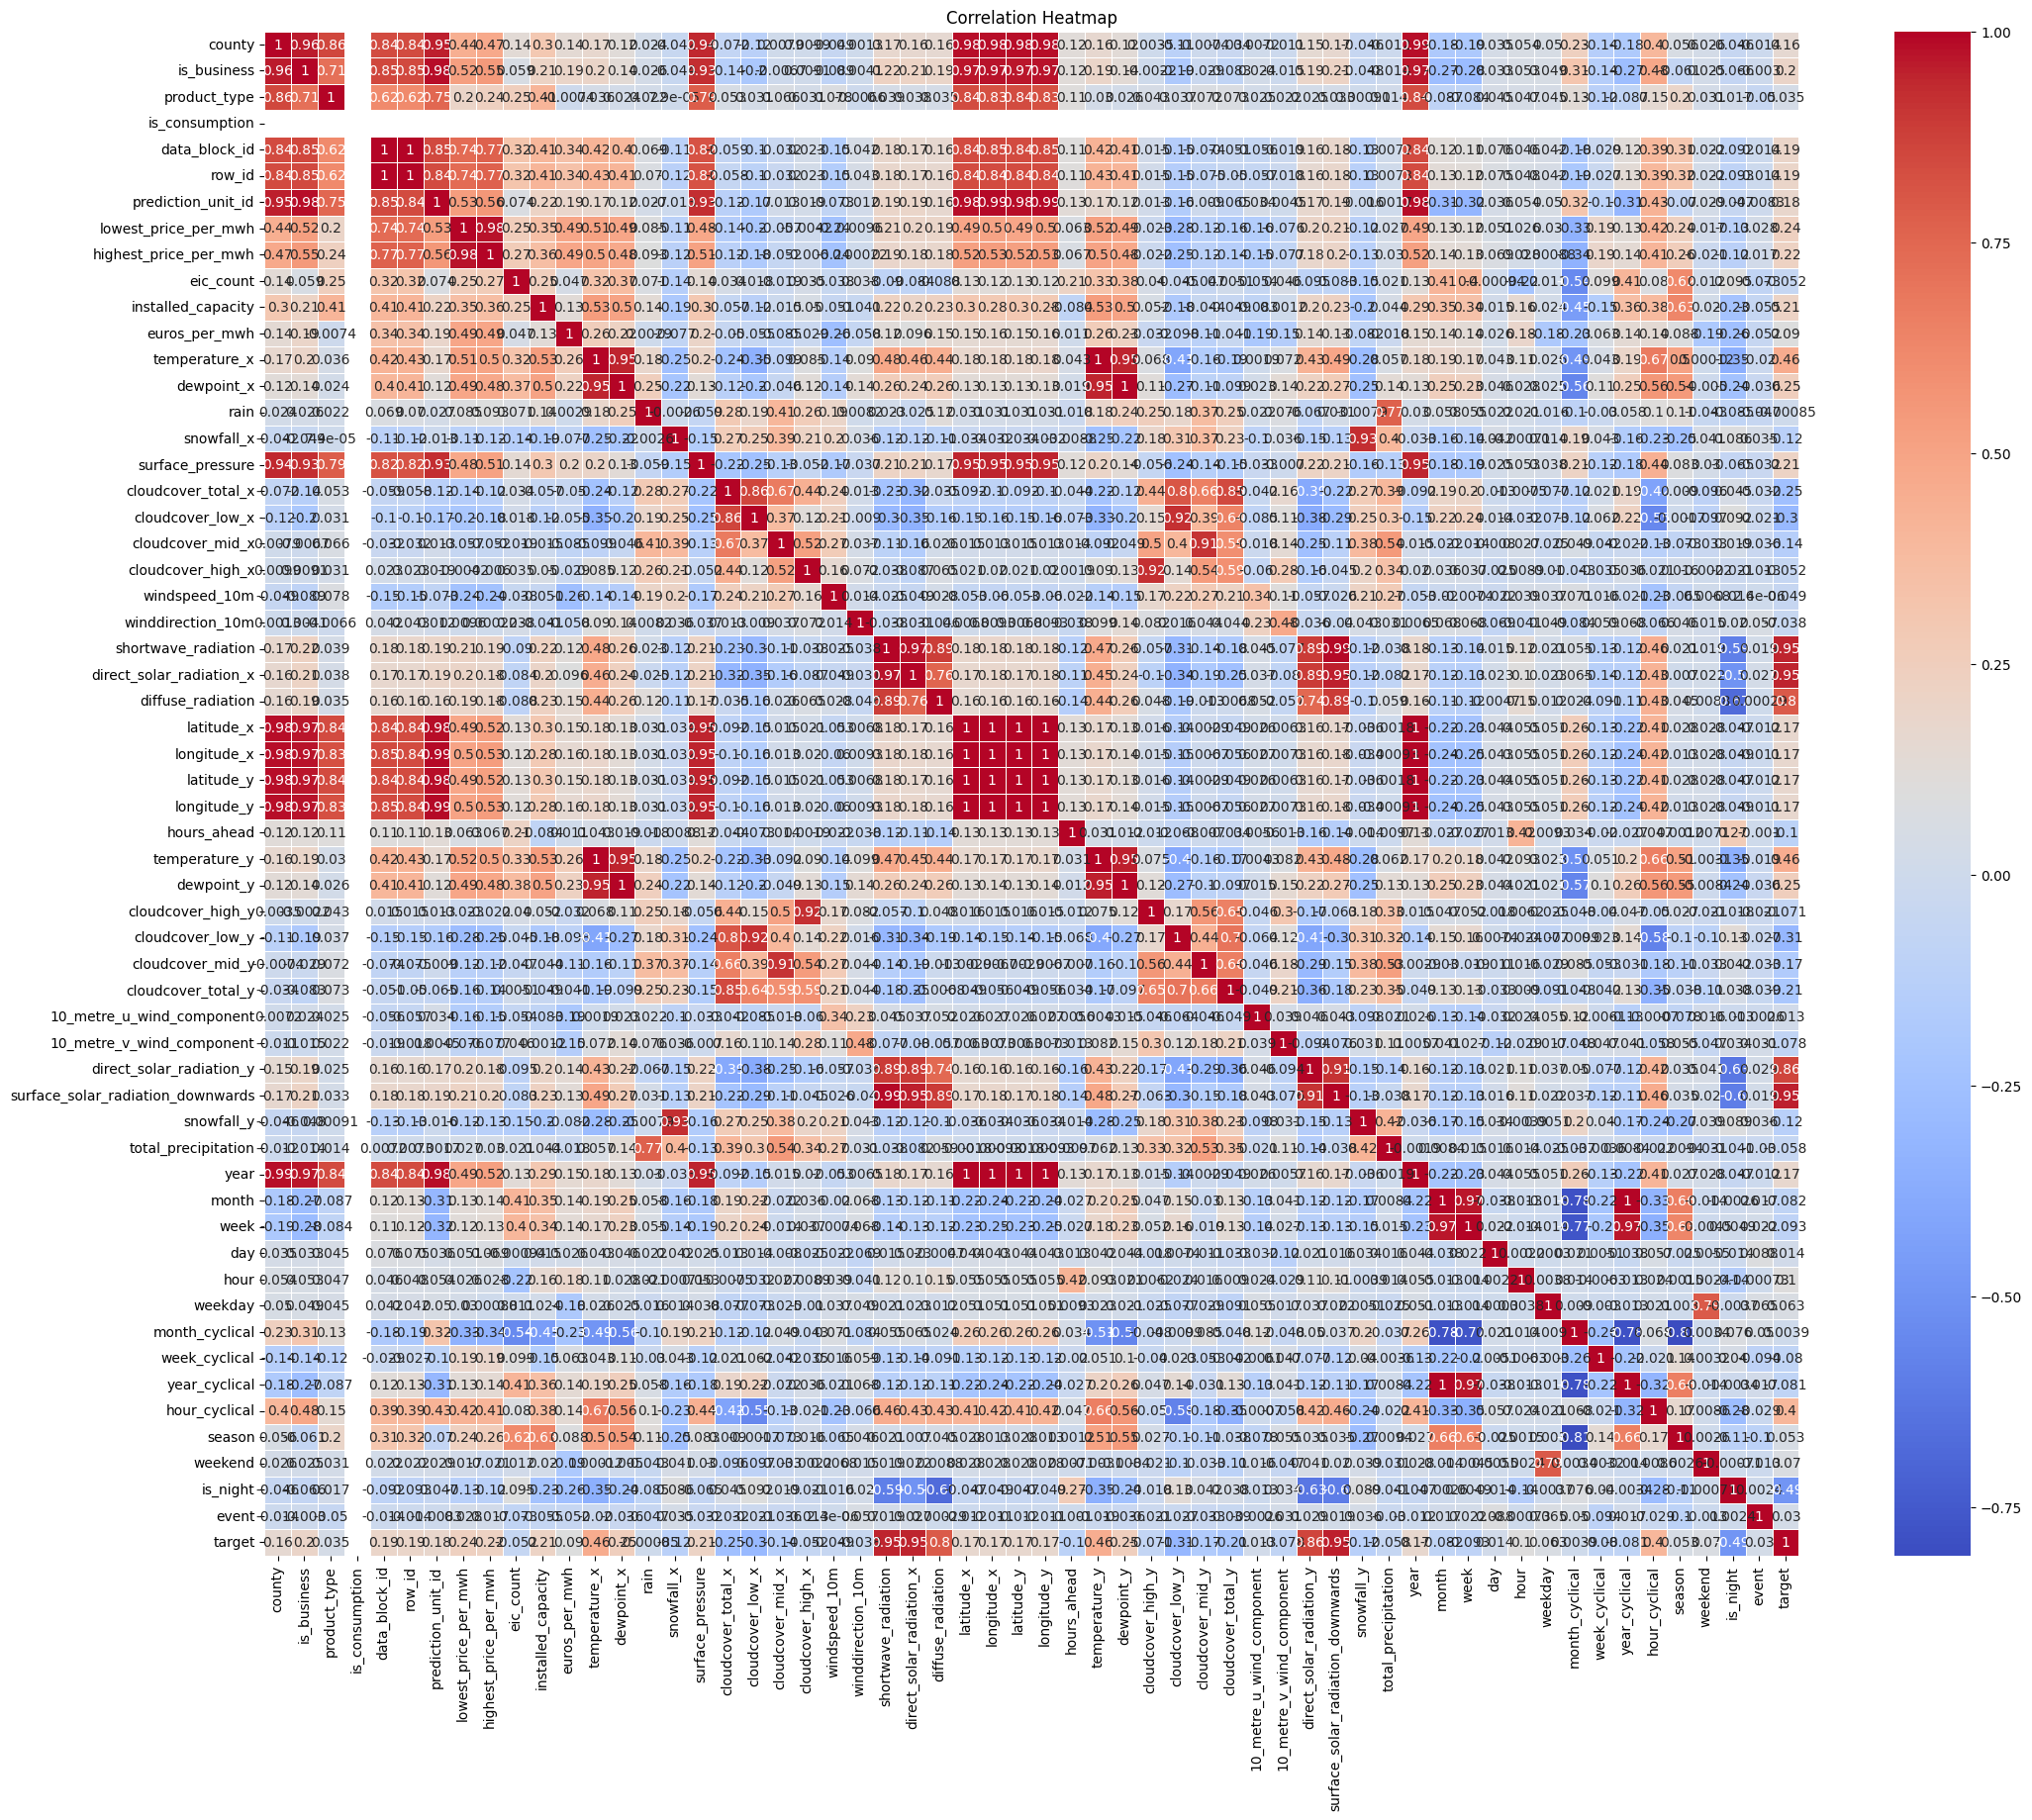

In [55]:
#Define which feature is the most correlated to the target
correlation_matrix = df_train_prod_gruped.corr()

plt.figure(figsize=(25, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [56]:
#For production, we assume that it is proportional to feature 'direct_solar_radiation'. We therefore use a rule of 3 to calculate production
df_leftovertrain_production2_grouped['y_model2'] = df_leftovertrain_production2_grouped['direct_solar_radiation_x'] * 53632.382 / 45470

#Define the dummy model colomn for production
df_leftovertrain_production2_grouped['y_dummy'] = 5368

In [57]:
df_leftovertrain_production2_grouped.head()

index  county  is_business  product_type  \
datetime                                                           
2022-11-22 03:00:00  83055716     509           33           111   
2022-11-22 04:00:00  97141788     512           38           130   
2022-11-22 05:00:00  97151310     512           38           130   
2022-11-22 06:00:00  97160832     512           38           130   
2022-11-22 07:00:00  97170354     512           38           130   

                     is_consumption  data_block_id    row_id  \
datetime                                                       
2022-11-22 03:00:00               0          26373  83108580   
2022-11-22 04:00:00               0          30843  97203612   
2022-11-22 05:00:00               0          30843  97213134   
2022-11-22 06:00:00               0          30843  97222656   
2022-11-22 07:00:00               0          30843  97232178   

                     prediction_unit_id  lowest_price_per_mwh  \
datetime                                                        
2022-11-22 03:00:00                2249               7163.19   
2022-11-22 04:00:00                2346               8377.29   
2022-11-22 05:00:00                2346               8377.29   
2022-11-22 06:00:00                2346               8377.29   
2022-11-22 07:00:00                2346               8377.29   

                     highest_price_per_mwh  eic_count  installed_capacity  \
datetime                                                                    
2022-11-22 03:00:00                 7670.0     2773.0            100754.3   
2022-11-22 04:00:00                 8970.0     3243.0            117831.3   
2022-11-22 05:00:00                 8970.0     3243.0            117831.3   
2022-11-22 06:00:00                 8970.0     3243.0            117831.3   
2022-11-22 07:00:00                 8970.0     3243.0            117831.3   

                     euros_per_mwh  temperature_x  dewpoint_x  rain  \
datetime                                                              
2022-11-22 03:00:00       11837.17    -280.858108 -388.187613   0.0   
2022-11-22 04:00:00       15180.69    -310.494820 -443.715586   0.0   
2022-11-22 05:00:00       20076.93    -308.304820 -442.424369   0.0   
2022-11-22 06:00:00       23745.66    -310.248423 -444.741532   0.0   
2022-11-22 07:00:00       20706.21    -309.791081 -445.386396   0.0   

                     snowfall_x  surface_pressure  cloudcover_total_x  \
datetime                                                                
2022-11-22 03:00:00    0.036419      59464.829054         5821.711712   
2022-11-22 04:00:00    0.071419      69559.265450         6823.051802   
2022-11-22 05:00:00    0.071419      69550.238198         6844.236486   
2022-11-22 06:00:00    0.048243      69545.160450         6848.495495   
2022-11-22 07:00:00    0.044459      69524.972883         6851.801802   

                     cloudcover_low_x  cloudcover_mid_x  cloudcover_high_x  \
datetime                                                                     
2022-11-22 03:00:00       5668.984234       3927.698198        2924.319820   
2022-11-22 04:00:00       6663.316216       4735.774324        3534.135586   
2022-11-22 05:00:00       6751.241441       4884.723423        4175.401802   
2022-11-22 06:00:00       6778.887838       5159.779730        4630.391892   
2022-11-22 07:00:00       6765.691441       5072.520721        4829.432883   

                     windspeed_10m  winddirection_10m  shortwave_radiation  \
datetime                                                                     
2022-11-22 03:00:00     226.226727       17092.572072           242.117117   
2022-11-22 04:00:00     268.549487       17688.698649           254.934685   
2022-11-22 05:00:00     257.070646       14057.440541           244.529279   
2022-11-22 06:00:00     250.014427       11753.097748           215.835586   
2022-11-22 07:00:00     245.760511       10530.446396           172.770270   

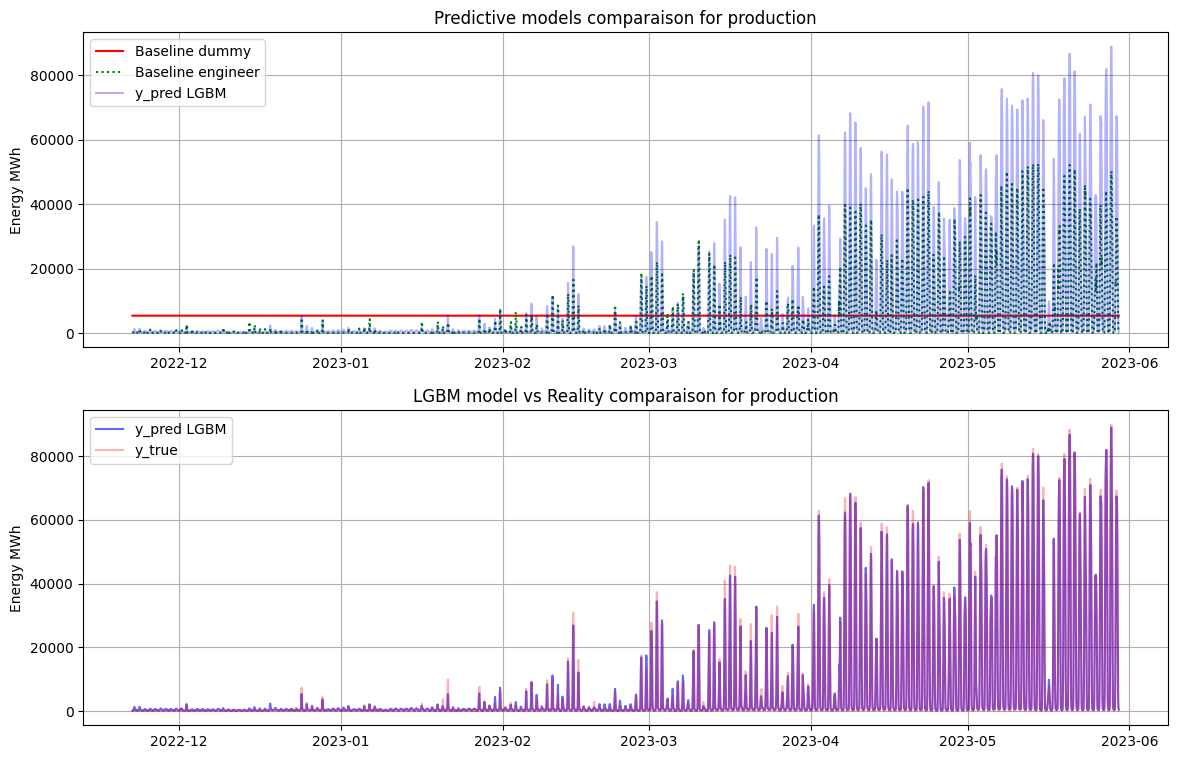

In [58]:
fig, (ax,ax1) = plt.subplots(2,1,figsize=(14,9))

#Compare the 3 models together: LGBM, dummy and engineer
ax.plot(df_leftovertrain_production2_grouped['y_dummy'], label='Baseline dummy', color='red', alpha=1)
ax.plot(df_leftovertrain_production2_grouped['y_model2'], label='Baseline engineer', color='green', linestyle=':', alpha=1)
ax.plot(df_leftovertrain_production2_grouped['y_pred'], label='y_pred LGBM', color='blue', alpha=0.3)
ax.set_title('Predictive models comparaison for production')
ax.set_ylabel('Energy MWh')
ax.grid()
ax.legend()

#Compare LGBM and reality
ax1.plot(df_leftovertrain_production2_grouped['y_pred'], label='y_pred LGBM', color='blue', alpha=0.6)
ax1.plot(df_leftovertrain_production2_grouped['y_true'], label='y_true', color='red', alpha=0.3)
ax1.set_title('LGBM model vs Reality comparaison for production')
ax1.set_ylabel('Energy MWh')
ax1.grid()
ax1.legend()

plt.show()

In [59]:
#Merge consumption and production dataset
df_leftovertrain_consumption2_grouped2['row_nb'] = range(1, len(df_leftovertrain_consumption2_grouped2) + 1)
df_leftovertrain_production2_grouped['row_nb'] = range(1, len(df_leftovertrain_production2_grouped) + 1)

df_leftovertrain_consumption2_grouped2.reset_index(inplace=True)
df_leftovertrain_production2_grouped.reset_index(inplace=True)

In [60]:
#Only keep the usefull features
df_leftovertrain_consumption2_grouped2.rename(columns={'y_pred':'y_pred_cons',
                                                       'y_true':'y_true_cons',
                                                       'y_dummy':'y_dummy_cons',
                                                       'y_pred_engineer':'y_pred_engineer_cons'
                                                       }, inplace=True)

df_leftovertrain_production2_grouped.rename(columns={'y_pred':'y_pred_prod',
                                                       'y_true':'y_true_prod',
                                                       'y_dummy':'y_dummy_prod',
                                                       'y_model2':'y_pred_engineer_prod'
                                                       }, inplace=True)

df_leftovertrain_final_merged = df_leftovertrain_production2_grouped.merge(df_leftovertrain_consumption2_grouped2, on='row_nb', how='left')
df_leftovertrain_final_merged.set_index('datetime_x', inplace=True)

In [61]:
df_leftovertrain_final_merged_reduced = df_leftovertrain_final_merged[['y_pred_cons',
                                                                       'y_true_cons',
                                                                       'y_pred_engineer_cons',
                                                                       'y_dummy_cons',
                                                                       'y_pred_prod',
                                                                       'y_true_prod',
                                                                       'y_pred_engineer_prod',
                                                                       'y_dummy_prod',
                                                                       'euros_per_mwh_x'
                                                                       ]]

In [62]:
#Calculate the difference between production and consumption for each model
df_leftovertrain_final_merged_reduced['diff_dummy'] = df_leftovertrain_final_merged_reduced['y_dummy_prod'] - df_leftovertrain_final_merged_reduced['y_dummy_cons']
df_leftovertrain_final_merged_reduced['diff_engineer'] = df_leftovertrain_final_merged_reduced['y_pred_engineer_prod'] - df_leftovertrain_final_merged_reduced['y_pred_engineer_cons']
df_leftovertrain_final_merged_reduced['diff_pred'] = df_leftovertrain_final_merged_reduced['y_pred_prod'] - df_leftovertrain_final_merged_reduced['y_pred_cons']
df_leftovertrain_final_merged_reduced['diff_true'] = df_leftovertrain_final_merged_reduced['y_true_prod'] - df_leftovertrain_final_merged_reduced['y_true_cons']
df_leftovertrain_final_merged_reduced.head()

/var/folders/qx/vs5kgv557012y73k70gg87640000gn/T/ipykernel_3935/2623690043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_leftovertrain_final_merged_reduced['diff_dummy'] = df_leftovertrain_final_merged_reduced['y_dummy_prod'] - df_leftovertrain_final_merged_reduced['y_dummy_cons']
/var/folders/qx/vs5kgv557012y73k70gg87640000gn/T/ipykernel_3935/2623690043.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_leftovertrain_final_merged_reduced['diff_engineer'] = df_leftovertrain_final_merged_reduced

y_pred_cons  y_true_cons  y_pred_engineer_cons  \
datetime_x                                                             
2022-11-22 03:00:00  19862.766714    19095.047             23125.866   
2022-11-22 04:00:00  33702.075003    32317.142             23468.071   
2022-11-22 05:00:00  35436.656922    34019.121             24996.958   
2022-11-22 06:00:00  42118.391813    40375.571             30043.967   
2022-11-22 07:00:00  47471.616821    47452.880             35689.789   

                     y_dummy_cons  y_pred_prod  y_true_prod  \
datetime_x                                                    
2022-11-22 03:00:00         27574    94.499730       46.464   
2022-11-22 04:00:00         27574    57.542673       47.927   
2022-11-22 05:00:00         27574    90.388793       68.625   
2022-11-22 06:00:00         27574   145.817809       54.354   
2022-11-22 07:00:00         27574   280.942016       68.741   

                     y_pred_engineer_prod  y_dummy_prod  euros_per_mwh_x  \
datetime_x                                                                 
2022-11-22 03:00:00            232.499224          5368         11837.17   
2022-11-22 04:00:00            256.705773          5368         15180.69   
2022-11-22 05:00:00            245.242729          5368         20076.93   
2022-11-22 06:00:00            213.759870          5368         23745.66   
2022-11-22 07:00:00            166.199528          5368         20706.21   

                     diff_dummy  diff_engineer     diff_pred  diff_true  
datetime_x                                                               
2022-11-22 03:00:00      -22206  -22893.366776 -19768.266984 -19048.583  
2022-11-22 04:00:00      -22206  -23211.365227 -33644.532330 -32269.215  
2022-11-22 05:00:00      -22206  -24751.715271 -35346.268129 -33950.496  
2022-11-22 06:00:00      -22206  -29830.207130 -41972.574004 -40321.217  
2022-11-22 07:00:00      -22206  -35523.589472 -47190.674805 -47384.139

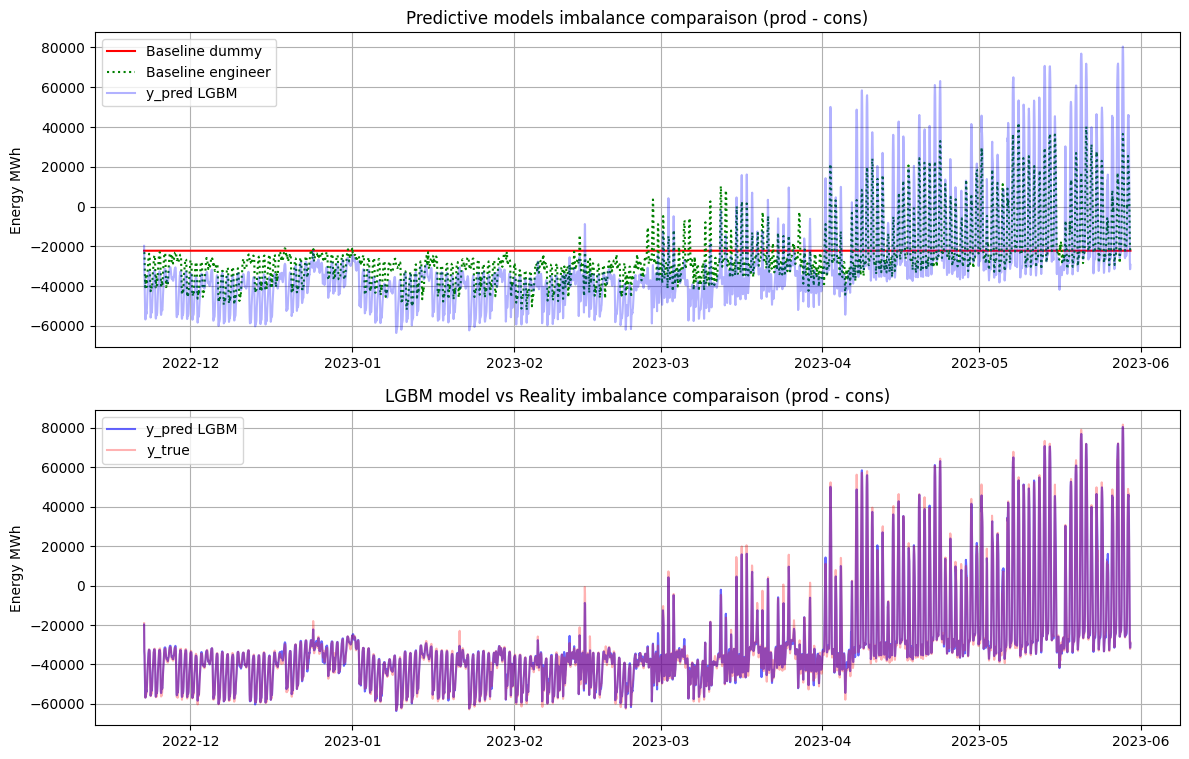

In [63]:
fig, (ax,ax1) = plt.subplots(2,1,figsize=(14,9))

#Compare the 3 models together: LGBM, dummy and engineer
ax.plot(df_leftovertrain_final_merged_reduced['diff_dummy'], label='Baseline dummy', color='red', alpha=1)
ax.plot(df_leftovertrain_final_merged_reduced['diff_engineer'], label='Baseline engineer', color='green', linestyle=':', alpha=1)
ax.plot(df_leftovertrain_final_merged_reduced['diff_pred'], label='y_pred LGBM', color='blue', alpha=0.3)
ax.set_title('Predictive models imbalance comparaison (prod - cons)')
ax.set_ylabel('Energy MWh')
ax.grid()
ax.legend()

#Compare LGBM model and reality
ax1.plot(df_leftovertrain_final_merged_reduced['diff_pred'], label='y_pred LGBM', color='blue', alpha=0.6)
ax1.plot(df_leftovertrain_final_merged_reduced['diff_true'], label='y_true', color='red', alpha=0.3)
ax1.set_title('LGBM model vs Reality imbalance comparaison (prod - cons)')
ax1.set_ylabel('Energy MWh')
ax1.grid()
ax1.legend()

plt.show()

In [64]:
#For the price of electricity we will keep the same value for each day to avoid to sum the price of electricity
df_train_reduced = df_train[['date2','euros_per_mwh']]
df_train_reduced_grouped = df_train_reduced.groupby(pd.Grouper(key='date2', freq='H')).first().reset_index()
df_train_reduced_grouped.rename(columns={'euros_per_mwh':'euros_per_mwh_true',
                                         'date2':'datetime_x'
                                         },inplace=True)

#Merge data together
df_leftovertrain_final_merged_reduced2 = df_leftovertrain_final_merged_reduced.reset_index()
df_leftovertrain_final_merged_reduced2 = df_leftovertrain_final_merged_reduced2.merge(df_train_reduced_grouped, on='datetime_x', how='left')

In [65]:
#Calculate the difference between reality and each model
df_leftovertrain_final_merged_reduced2['diff_true_dummy'] = df_leftovertrain_final_merged_reduced2['diff_true'] - df_leftovertrain_final_merged_reduced2['diff_dummy']
df_leftovertrain_final_merged_reduced2['diff_true_engineer'] = df_leftovertrain_final_merged_reduced2['diff_true'] - df_leftovertrain_final_merged_reduced2['diff_engineer']
df_leftovertrain_final_merged_reduced2['diff_true_pred'] = df_leftovertrain_final_merged_reduced2['diff_true'] - df_leftovertrain_final_merged_reduced2['diff_pred']
df_leftovertrain_final_merged_reduced2['diff_true_true'] = df_leftovertrain_final_merged_reduced2['diff_true'] - df_leftovertrain_final_merged_reduced2['diff_true']

In [66]:
#Calculate the cost of imbalance
df_leftovertrain_final_merged_reduced2['Cost_of_balance_dummy'] = df_leftovertrain_final_merged_reduced2['diff_true_dummy'] * df_leftovertrain_final_merged_reduced2['euros_per_mwh_true']*(-1)
df_leftovertrain_final_merged_reduced2['Cost_of_balance_engineer'] = df_leftovertrain_final_merged_reduced2['diff_true_engineer'] * df_leftovertrain_final_merged_reduced2['euros_per_mwh_true']*(-1)
df_leftovertrain_final_merged_reduced2['Cost_of_balance_pred'] = df_leftovertrain_final_merged_reduced2['diff_true_pred'] * df_leftovertrain_final_merged_reduced2['euros_per_mwh_true']*(-1)
df_leftovertrain_final_merged_reduced2['Cost_of_balance_true'] = df_leftovertrain_final_merged_reduced2['diff_true_true'] * df_leftovertrain_final_merged_reduced2['euros_per_mwh_true'] *(-1)

#Sum the cost of imbalance for each day
df_leftovertrain_final_merged_reduced2['Cumul_cost_dummy'] = df_leftovertrain_final_merged_reduced2['Cost_of_balance_dummy'].cumsum()
df_leftovertrain_final_merged_reduced2['Cumul_cost_engineer'] = df_leftovertrain_final_merged_reduced2['Cost_of_balance_engineer'].cumsum()
df_leftovertrain_final_merged_reduced2['Cumul_cost_pred'] = df_leftovertrain_final_merged_reduced2['Cost_of_balance_pred'].cumsum()
df_leftovertrain_final_merged_reduced2['Cumul_cost_true'] = df_leftovertrain_final_merged_reduced2['Cost_of_balance_true'].cumsum()

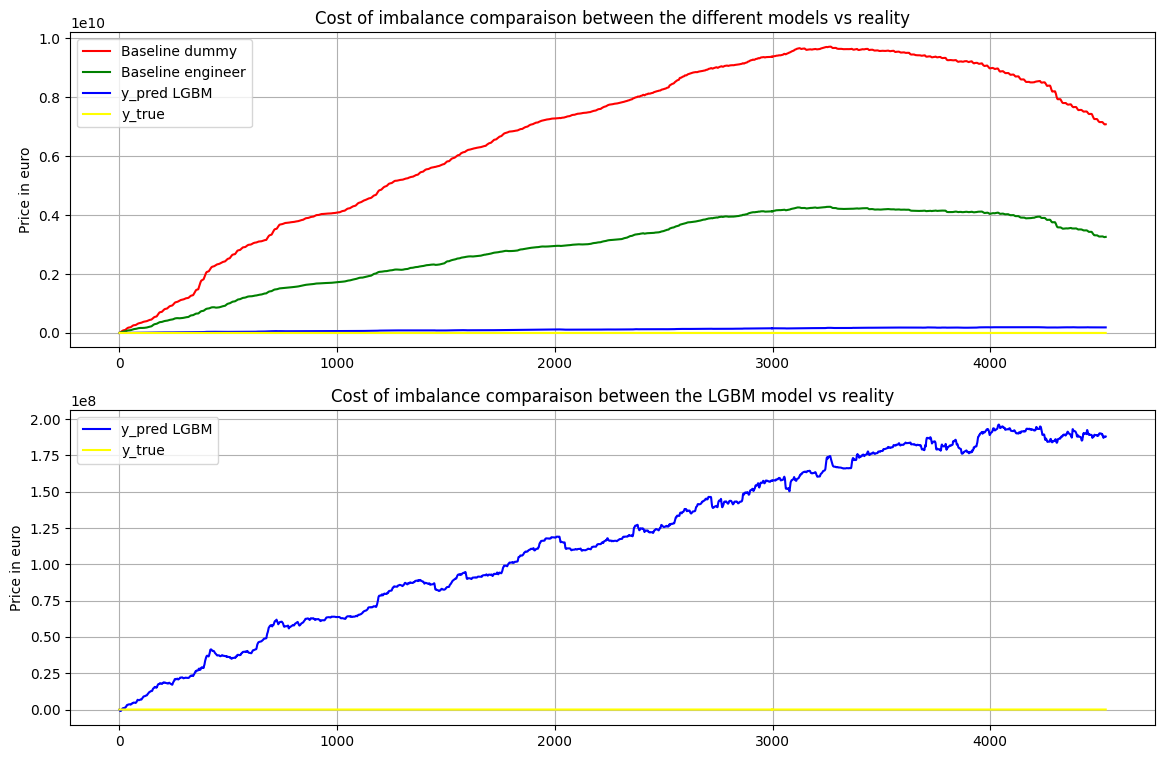

In [67]:
fig, (ax,ax2) = plt.subplots(2,1,figsize=(14,9))

#Compare the 3 models together: LGBM, dummy and engineer
ax.plot(df_leftovertrain_final_merged_reduced2['Cumul_cost_dummy'], label='Baseline dummy', color='red', alpha=1)
ax.plot(df_leftovertrain_final_merged_reduced2['Cumul_cost_engineer'], label='Baseline engineer', color='green', alpha=1)
ax.plot(df_leftovertrain_final_merged_reduced2['Cumul_cost_pred'], label='y_pred LGBM', color='blue', alpha=1)
ax.plot(df_leftovertrain_final_merged_reduced2['Cumul_cost_true'], label='y_true', color='yellow', alpha=1)

ax.set_title('Cost of imbalance comparaison between the different models vs reality')
ax.set_ylabel('Price in euro')
ax.grid()
ax.legend()

#Compare LGBM and reality
ax2.plot(df_leftovertrain_final_merged_reduced2['Cumul_cost_pred'], label='y_pred LGBM', color='blue', alpha=1)
ax2.plot(df_leftovertrain_final_merged_reduced2['Cumul_cost_true'], label='y_true', color='yellow', alpha=1)
ax2.set_title('Cost of imbalance comparaison between the LGBM model vs reality')
ax2.set_ylabel('Price in euro')
ax2.grid()
ax2.legend()

plt.show()

In [68]:
#Show the last row so that we can kmow the last value for cumul cost
df_leftovertrain_final_merged_reduced_last_point = df_leftovertrain_final_merged_reduced2.tail(1)
df_leftovertrain_final_merged_reduced_last_point

datetime_x   y_pred_cons  y_true_cons  y_pred_engineer_cons  \
4530 2023-05-29 23:00:00  29798.637309    28903.833             22244.742   

      y_dummy_cons  y_pred_prod  y_true_prod  y_pred_engineer_prod  \
4530         27574     490.3135      112.655                   0.0   

      y_dummy_prod  euros_per_mwh_x  diff_dummy  diff_engineer     diff_pred  \
4530          5368          5022.55      -22206     -22244.742 -29308.323809   

      diff_true  euros_per_mwh_true  diff_true_dummy  diff_true_engineer  \
4530 -28791.178              139.02        -6585.178           -6546.436   

      diff_true_pred  diff_true_true  Cost_of_balance_dummy  \
4530      517.145809             0.0           915471.44556   

      Cost_of_balance_engineer  Cost_of_balance_pred  Cost_of_balance_true  \
4530              910085.53272          -71893.61037                  -0.0   

      Cumul_cost_dummy  Cumul_cost_engineer  Cumul_cost_pred  Cumul_cost_true  
4530      7.084301e+09         3.260378e+09     1.881008e+08              0.0

In [69]:
#Calculate the amount that will be saved between different models
Diff_pred_dummy = df_leftovertrain_final_merged_reduced_last_point['Cumul_cost_dummy'] - df_leftovertrain_final_merged_reduced_last_point['Cumul_cost_pred']
Diff_pred_engineer = df_leftovertrain_final_merged_reduced_last_point['Cumul_cost_engineer'] - df_leftovertrain_final_merged_reduced_last_point['Cumul_cost_pred']

In [70]:
print(f'Compared to the dummy baseline, the LGBM model helped reduced the cost of imbalance by {Diff_pred_dummy} euro')
print(f'Compared to the engineer baseline, the LGBM model helped reduced the cost of imbalance by {Diff_pred_engineer} euro')

Compared to the dummy baseline, the LGBM model helped reduced the cost of imbalance by 4530    6.896201e+09
dtype: float64 euro
Compared to the engineer baseline, the LGBM model helped reduced the cost of imbalance by 4530    3.072278e+09
dtype: float64 euro
